## **Algoritmo de filtraje no lineal basado en Operador de Koopman aplicado a epidemiología**

### **Capítulo 5: **

**Autor: Diego Olguín.**

**Supervisores: Héctor Ramírez y Axel Osses.**

In [584]:
chapter = "chapter4/"
img_path = "img/content/"+chapter

In [585]:
# Librerías generales
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.integrate import odeint
import seaborn as sns

sns.set_theme()

from sklearn.gaussian_process.kernels import Matern, ConstantKernel as Cte

# Plotly
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots

# Librerías propias
import os

# Dependencias de kerKKF
from kkf.DynamicalSystems import DynamicalSystem
from kkf.kEDMD import KoopmanOperator
import kkf.applyKKF as kkf

# Paralelización
import multiprocessing
from joblib import Parallel, delayed
from tqdm import tqdm

# Pandas
import pandas as pd

# Para medir el tiempo
from time import time

# Dependencias de PyMC 
import arviz as az
import pymc as pm
import pytensor
from pymc.ode import DifferentialEquation
import pytensor.tensor as pt
from pytensor.compile.ops import as_op

In [586]:
# Configuración de parámetros para Matplotlib
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'axes.labelsize': 20})
plt.rcParams.update({'axes.titlesize': 20})
plt.rcParams.update({'legend.fontsize': 20})
plt.rcParams.update({'xtick.labelsize': 20})
plt.rcParams.update({'ytick.labelsize': 20})
plt.rcParams.update({'figure.figsize': (14, 8)})
plt.rcParams.update({'figure.titlesize': 24})

In [587]:
# Ajustar directorio para las imagénes
root = "/Users/diegoolguin/Koopman_nonlinear_filter"
if not os.getcwd()==root:
    os.chdir(root)

In [588]:
# Se fija la semilla aleatoria
np.random.seed(42)

In [589]:
np.random.seed(42)

# Dinámica con los parámetros constantes
def f(x, beta, gamma):
    S, I, R = x
    return x + np.array([
        -beta*S*I,
        beta*S*I - gamma*I,
        gamma*I
    ])

# Observación
g = lambda x: np.array([x[0], x[1]])

# Parámetros
beta = 1.3
gamma = 0.5

# Condición inicial
x0 = np.array([0.9, 0.1, 0])

# Dimensiones
nx, ny = len(x0), g(x0).shape[0]

# Covarianzas
sigma = 0.001
Q = np.diag([sigma, sigma, sigma, 1, 1])
R = sigma*np.eye(ny)

iters = 20

# Datos sintéticos
x, y = np.zeros((nx, iters)), np.zeros((ny, iters))
x[:, 0] = x0
for i in range(1, iters):
    x[:, i] = f(x[:, i-1], beta, gamma)
    y[:, i] = g(x[:, i]) + np.random.multivariate_normal(np.zeros(ny), R)

In [590]:
@as_op(itypes=[pt.dvector], otypes=[pt.dmatrix])
def pytensor_forward_model_matrix(theta):
    beta_, gamma_ = theta
    x_, y_ = np.zeros((nx, iters)), np.zeros((ny, iters))
    x_[:, 0] = x0

    for i in range(1, iters):
        x_[:, i] = f(x_[:, i-1], beta_, gamma_)
        y_[:, i] = g(x_[:, i]) + np.random.multivariate_normal(np.zeros(ny), R)

    return y_

In [591]:
theta = np.array([0.1, 0.1])  # least squares solution used to inform the priors
with pm.Model() as model:
    # Priors
    beta_ = pm.Uniform("beta", lower=0, upper=2, initval=theta[0])
    gamma_ = pm.Uniform("gamma", lower=0, upper=1, initval=theta[1])

    # Ode solution function
    y_ = pytensor_forward_model_matrix(
        pm.math.stack([beta_, gamma_])
    )

    # Likelihood
    pm.Normal("Y_obs", mu=y_, sigma=0.01, observed=y)

In [592]:
np.random.seed(42)

vars_list = list(model.values_to_rvs.keys())[:-1]

# MCMC con Metropolis
tune = draws = 20000
met_time = time()
with model:
    trace_DEMZ = pm.sample(step=[pm.DEMetropolisZ(vars_list)], tune=tune, draws=draws, chains=8, cores=8)
met_time = time() - met_time
trace = trace_DEMZ
az.summary(trace)

Multiprocess sampling (8 chains in 8 jobs)
DEMetropolisZ: [beta, gamma]


Output()

/Users/diegoolguin/anaconda3/envs/thesis/lib/python3.12/site-packages/pymc/step_methods/metropolis.py:1194: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/Users/diegoolguin/anaconda3/envs/thesis/lib/python3.12/site-packages/pymc/step_methods/metropolis.py:1194: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/Users/diegoolguin/anaconda3/envs/thesis/lib/python3.12/site-packages/pymc/step_methods/metropolis.py:1194: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/Users/diegoolguin/anaconda3/envs/thesis/lib/python3.12/site-packages/pymc/step_methods/metropolis.py:1194: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/Users/diegoolguin/anaconda3/envs/thesis/lib/python3.12/site-packages/pymc/step_methods/metropolis.py:1194: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/Users/diegoolguin/anaconda3/envs/thesis/lib/python3.12/site-packages/pymc/step_methods/metropolis.p

Sampling 8 chains for 20_000 tune and 20_000 draw iterations (160_000 + 160_000 draws total) took 1976 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
beta   1.577  0.315   1.236      2.0      0.107    0.079      12.0     406.0   
gamma  0.682  0.232   0.447      1.0      0.078    0.058      12.0     444.0   

       r_hat  
beta    1.72  
gamma   1.69

In [593]:
print(f"Tiempo de ejecución: {met_time:.2f} s")

Tiempo de ejecución: 1978.67 s


In [594]:
params = ['beta', 'gamma']
summ = az.summary(trace)

print("Parámetros estimados:")
for i in range(len(params)):
    z1 = summ['mean'][params[i]] - 1.96*summ['sd'][params[i]]
    z2 = summ['mean'][params[i]] + 1.96*summ['sd'][params[i]]
    print(f"{params[i]}: {summ['mean'][params[i]]} ({z1}, {z2})")

Parámetros estimados:
beta: 1.577 (0.9596, 2.1944)
gamma: 0.682 (0.22728000000000004, 1.13672)


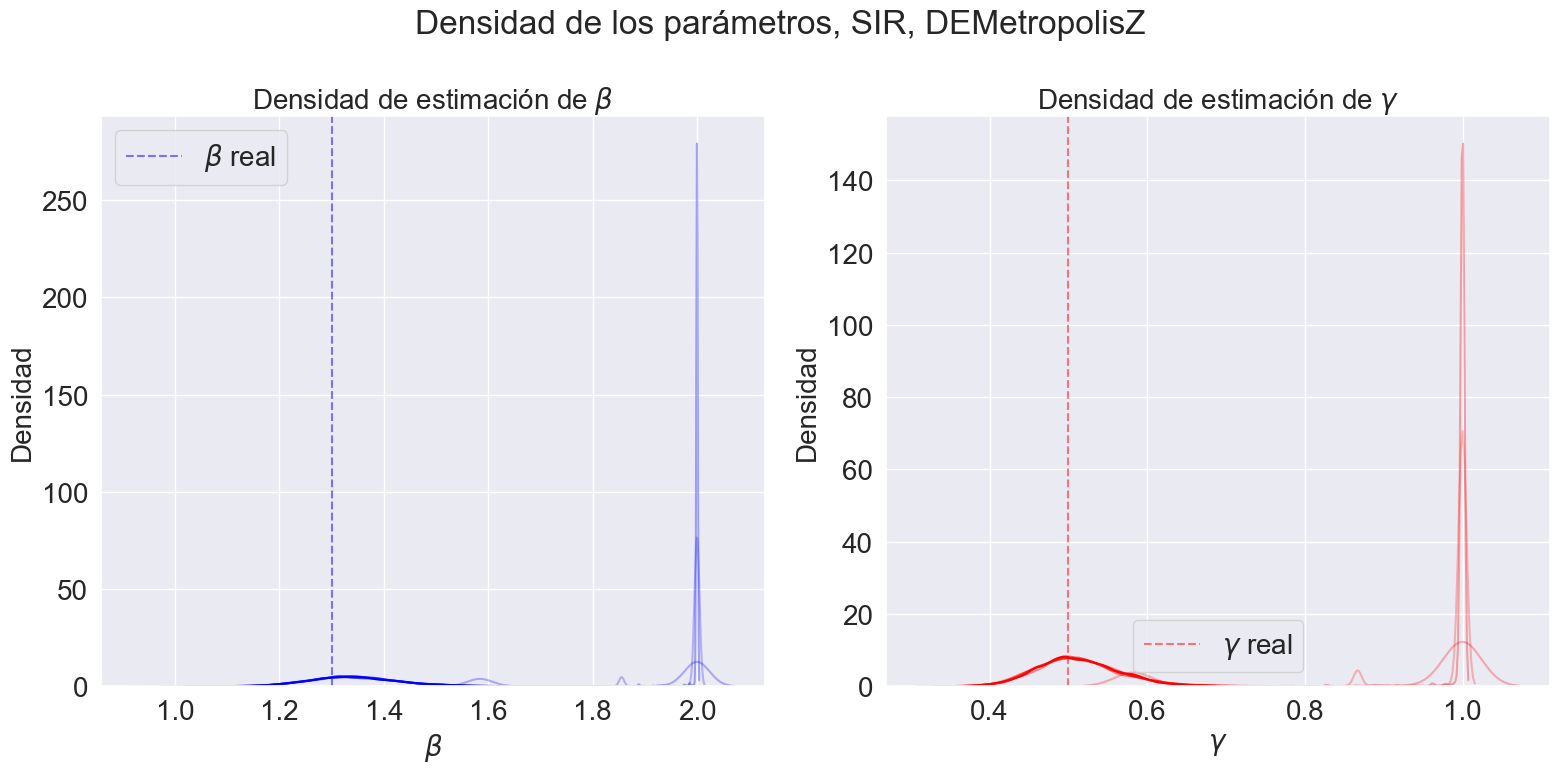

In [595]:
beta_trace = trace.posterior["beta"].shape
gamma_trace = trace.posterior["gamma"].shape

fig, ax = plt.subplots(1, 2, figsize=(16, 8))

for i in range(8):
    sns.kdeplot(trace.posterior["beta"][i], ax=ax[0], color='blue', alpha=1/(i*0.5+1))
    sns.kdeplot(trace.posterior["gamma"][i], ax=ax[1], color='red', alpha=1/(i*0.5+1))

ax[0].axvline(beta, color='blue', linestyle='--', label=r'$\beta$ real', alpha=0.5)
ax[0].set_title(r'Densidad de estimación de $\beta$')
ax[0].set_xlabel(r'$\beta$')
ax[0].set_ylabel('Densidad')
ax[0].legend()

ax[1].axvline(gamma, color='red', linestyle='--', label=r'$\gamma$ real', alpha=0.5)
ax[1].set_title(r'Densidad de estimación de $\gamma$')
ax[1].set_xlabel(r'$\gamma$')
ax[1].set_ylabel('Densidad')
ax[1].legend()

fig.suptitle(r'Densidad de los parámetros, SIR, DEMetropolisZ')
plt.tight_layout()
plt.savefig(img_path+'DEMetropolis_sir_params_density.pdf')

beta: 1.577 (0.9596, 2.1944)
gamma: 0.682 (0.22728000000000004, 1.13672)


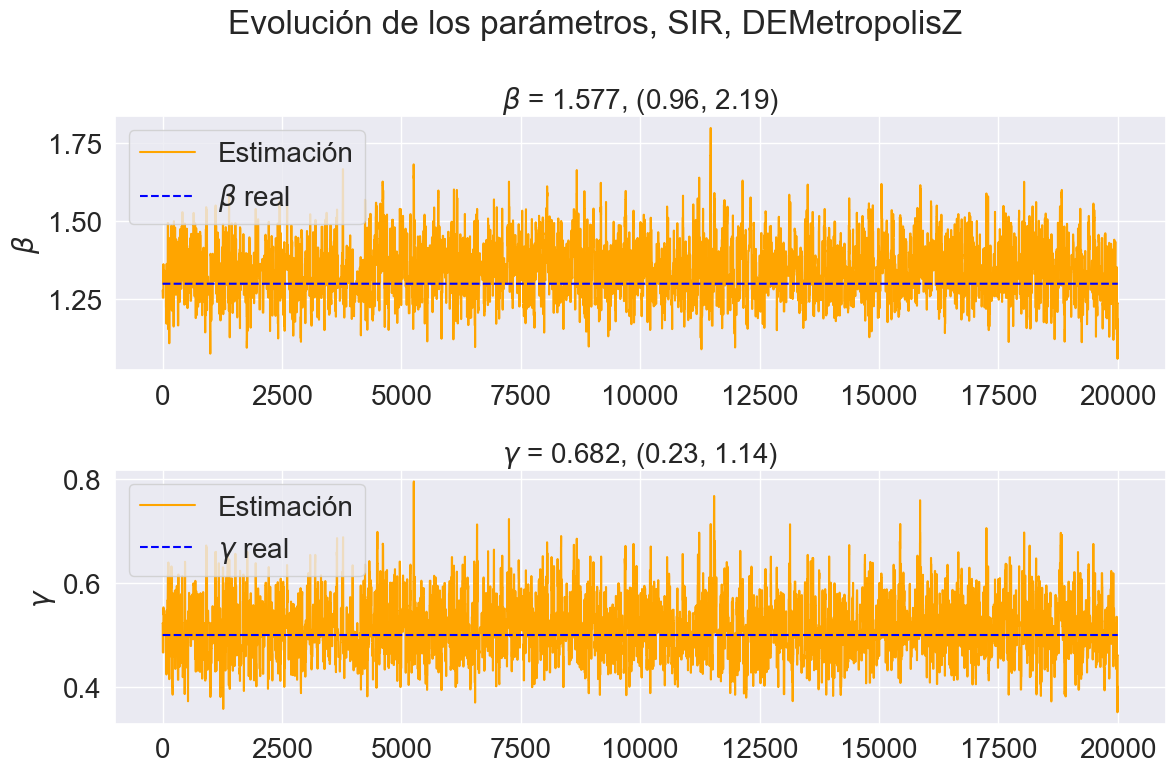

In [596]:
# Gráfico de la primera cadena a través de las iteraciones
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

z1 = summ['mean']['beta'] - 1.96*summ['sd']['beta']
z2 = summ['mean']['beta'] + 1.96*summ['sd']['beta']
print(f"{'beta'}: {summ['mean']['beta']} ({z1}, {z2})")

ax[0].plot(trace.posterior["beta"][0], c='orange', label='Estimación')
ax[0].plot([1.3]*len(trace.posterior["beta"][0]), c='blue', linestyle='--', label=r'$\beta$ real')
ax[0].set_title(r'$\beta$ = {}, ({:.2f}, {:.2f})'.format(summ['mean']['beta'], z1, z2))
ax[0].set_ylabel(r'$\beta$')
ax[0].legend()

z1 = summ['mean']['gamma'] - 1.96*summ['sd']['gamma']
z2 = summ['mean']['gamma'] + 1.96*summ['sd']['gamma']
print(f"{'gamma'}: {summ['mean']['gamma']} ({z1}, {z2})")

ax[1].plot(trace.posterior["gamma"][0], c='orange', label='Estimación')
ax[1].plot([0.5]*len(trace.posterior["gamma"][0]), c='blue', linestyle='--', label=r'$\gamma$ real')
ax[1].set_title(r'$\gamma$ = {}, ({:.2f}, {:.2f})'.format(summ['mean']['gamma'], z1, z2))
ax[1].set_ylabel(r'$\gamma$')
ax[1].legend()

fig.suptitle('Evolución de los parámetros, SIR, DEMetropolisZ')
plt.tight_layout()
plt.savefig(img_path+'DEMetropolis_sir_params_trace.pdf')

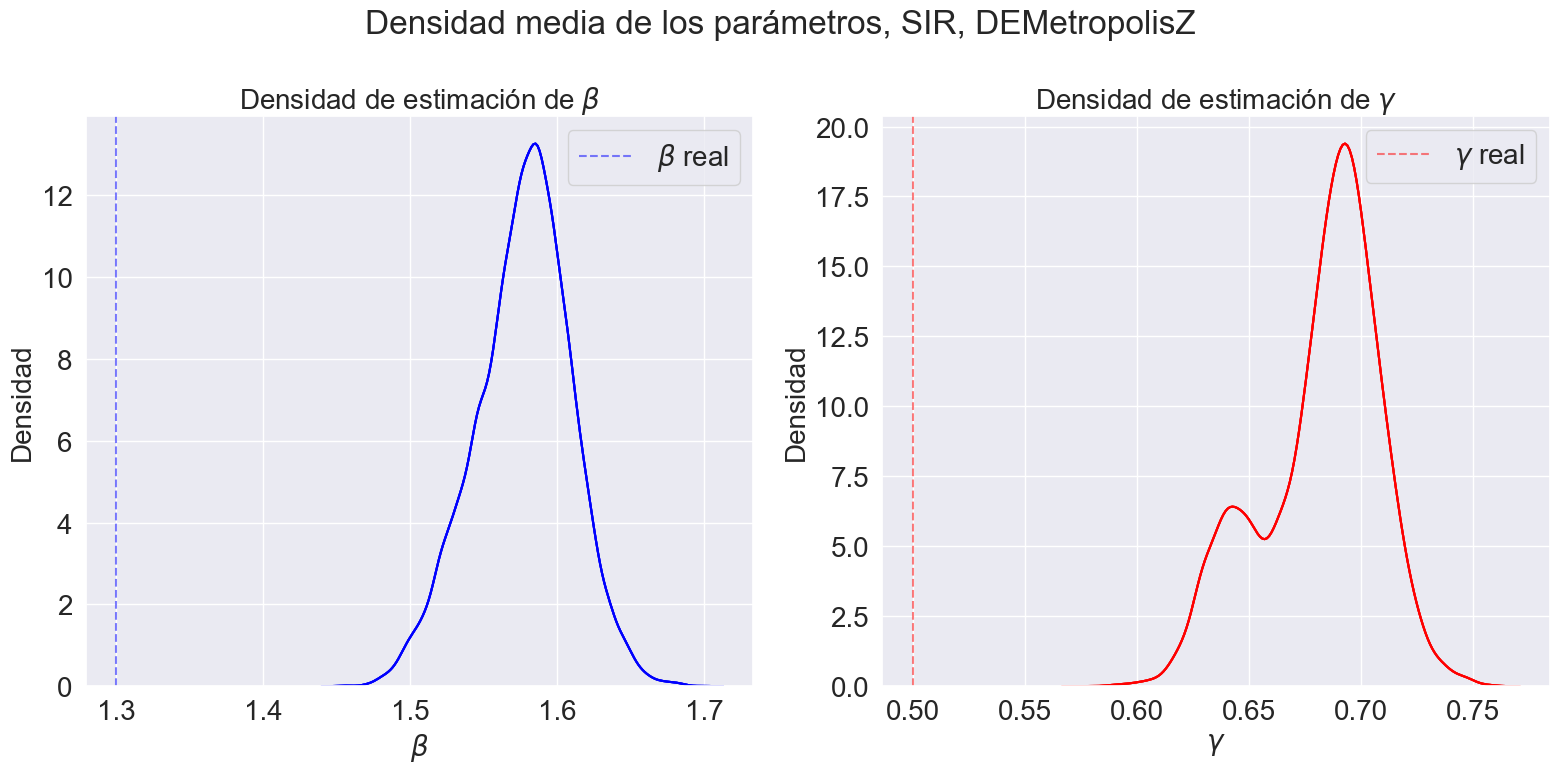

In [597]:
beta_trace = trace.posterior["beta"].shape
gamma_trace = trace.posterior["gamma"].shape

fig, ax = plt.subplots(1, 2, figsize=(16, 8))

for i in range(8):
    sns.kdeplot(trace.posterior["beta"].mean(axis=0), ax=ax[0], color='blue', alpha=1/(i*0.5+1))
    sns.kdeplot(trace.posterior["gamma"].mean(axis=0), ax=ax[1], color='red', alpha=1/(i*0.5+1))

ax[0].axvline(beta, color='blue', linestyle='--', label=r'$\beta$ real', alpha=0.5)
ax[0].set_title(r'Densidad de estimación de $\beta$')
ax[0].set_xlabel(r'$\beta$')
ax[0].set_ylabel('Densidad')
ax[0].legend()

ax[1].axvline(gamma, color='red', linestyle='--', label=r'$\gamma$ real', alpha=0.5)
ax[1].set_title(r'Densidad de estimación de $\gamma$')
ax[1].set_xlabel(r'$\gamma$')
ax[1].set_ylabel('Densidad')
ax[1].legend()

fig.suptitle(r'Densidad media de los parámetros, SIR, DEMetropolisZ')
plt.tight_layout()
plt.savefig(img_path+'DEMetropolis_sir_params_density_mean.pdf')

### SIR con pérdida de inmunidad

In [598]:
np.random.seed(42)

# Dinámica con los parámetros constantes
def f(x, alpha, beta, gamma):
    S, I, R = x
    return x + np.array([
        alpha*R-beta*S*I,
        beta*S*I - gamma*I,
        gamma*I - alpha*R
    ])

# Observación
g = lambda x: np.array([x[0], x[1]])

# Parámetros
alpha = 0.2
beta = 1.3
gamma = 0.5

# Condición inicial
x0 = np.array([0.9, 0.1, 0])

# Dimensiones
nx, ny = len(x0), g(x0).shape[0]

# Covarianzas
sigma = 0.001
Q = np.diag([sigma, sigma, sigma, 1, 1])
R = sigma*np.eye(ny)

iters = 20

# Datos sintéticos
x, y = np.zeros((nx, iters)), np.zeros((ny, iters))
x[:, 0] = x0
for i in range(1, iters):
    x[:, i] = f(x[:, i-1], alpha, beta, gamma)
    y[:, i] = g(x[:, i]) + np.random.multivariate_normal(np.zeros(ny), R)

@as_op(itypes=[pt.dvector], otypes=[pt.dmatrix])
def pytensor_forward_model_matrix(theta):
    alpha_, beta_, gamma_ = theta
    x_, y_ = np.zeros((nx, iters)), np.zeros((ny, iters))
    x_[:, 0] = x0

    for i in range(1, iters):
        x_[:, i] = f(x_[:, i-1], alpha_, beta_, gamma_)
        y_[:, i] = g(x_[:, i]) + np.random.multivariate_normal(np.zeros(ny), R)

    return y_

theta = np.array([0.1, 0.1, 0.1])  
with pm.Model() as model:
    # Priors
    alpha_ = pm.Uniform("alpha", lower=0, upper=1)
    beta_ = pm.Uniform("beta", lower=0, upper=2)
    gamma_ = pm.Uniform("gamma", lower=0, upper=1)

    # Ode solution function
    y_ = pytensor_forward_model_matrix(
        pm.math.stack([alpha_, beta_, gamma_])
    )

    # Likelihood
    pm.Normal("Y_obs", mu=y_, sigma=0.01, observed=y)

np.random.seed(42)

vars_list = list(model.values_to_rvs.keys())[:-1]

# MCMC con Metropolis
tune = draws = 20000
met_time = time()
with model:
    trace_DEMZ = pm.sample(step=[pm.DEMetropolisZ(vars_list)], tune=tune, draws=draws, chains=8, cores=8)
met_time = time() - met_time

Multiprocess sampling (8 chains in 8 jobs)
DEMetropolisZ: [alpha, beta, gamma]


Output()

/Users/diegoolguin/anaconda3/envs/thesis/lib/python3.12/site-packages/pymc/step_methods/metropolis.py:1194: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/Users/diegoolguin/anaconda3/envs/thesis/lib/python3.12/site-packages/pymc/step_methods/metropolis.py:1194: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/Users/diegoolguin/anaconda3/envs/thesis/lib/python3.12/site-packages/pymc/step_methods/metropolis.py:1194: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/Users/diegoolguin/anaconda3/envs/thesis/lib/python3.12/site-packages/pymc/step_methods/metropolis.py:1194: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/Users/diegoolguin/anaconda3/envs/thesis/lib/python3.12/site-packages/pymc/step_methods/metropolis.py:1194: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/Users/diegoolguin/anaconda3/envs/thesis/lib/python3.12/site-packages/pymc/step_methods/metropolis.p

Sampling 8 chains for 20_000 tune and 20_000 draw iterations (160_000 + 160_000 draws total) took 2239 seconds.


In [599]:
trace = trace_DEMZ
az.summary(trace)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha  0.187  0.029   0.135    0.243      0.000    0.000    9411.0   15068.0   
beta   1.315  0.087   1.149    1.479      0.001    0.001    9934.0   13791.0   
gamma  0.501  0.037   0.432    0.573      0.000    0.000   10055.0   14868.0   

       r_hat  
alpha    1.0  
beta     1.0  
gamma    1.0

In [600]:
print(f"Tiempo de ejecución: {met_time:.2f} s")

Tiempo de ejecución: 2240.61 s


In [601]:
params = ['alpha', 'beta', 'gamma']
summ = az.summary(trace)

print("Parámetros estimados:")
for i in range(len(params)):
    z1 = summ['mean'][params[i]] - 1.96*summ['sd'][params[i]]
    z2 = summ['mean'][params[i]] + 1.96*summ['sd'][params[i]]
    print(f"{params[i]}: {summ['mean'][params[i]]} ({z1}, {z2})")

Parámetros estimados:
alpha: 0.187 (0.13016, 0.24384)
beta: 1.315 (1.14448, 1.48552)
gamma: 0.501 (0.42847999999999997, 0.57352)


alpha: 0.187 (0.13016, 0.24384)
beta: 1.315 (1.14448, 1.48552)
gamma: 0.501 (0.42847999999999997, 0.57352)


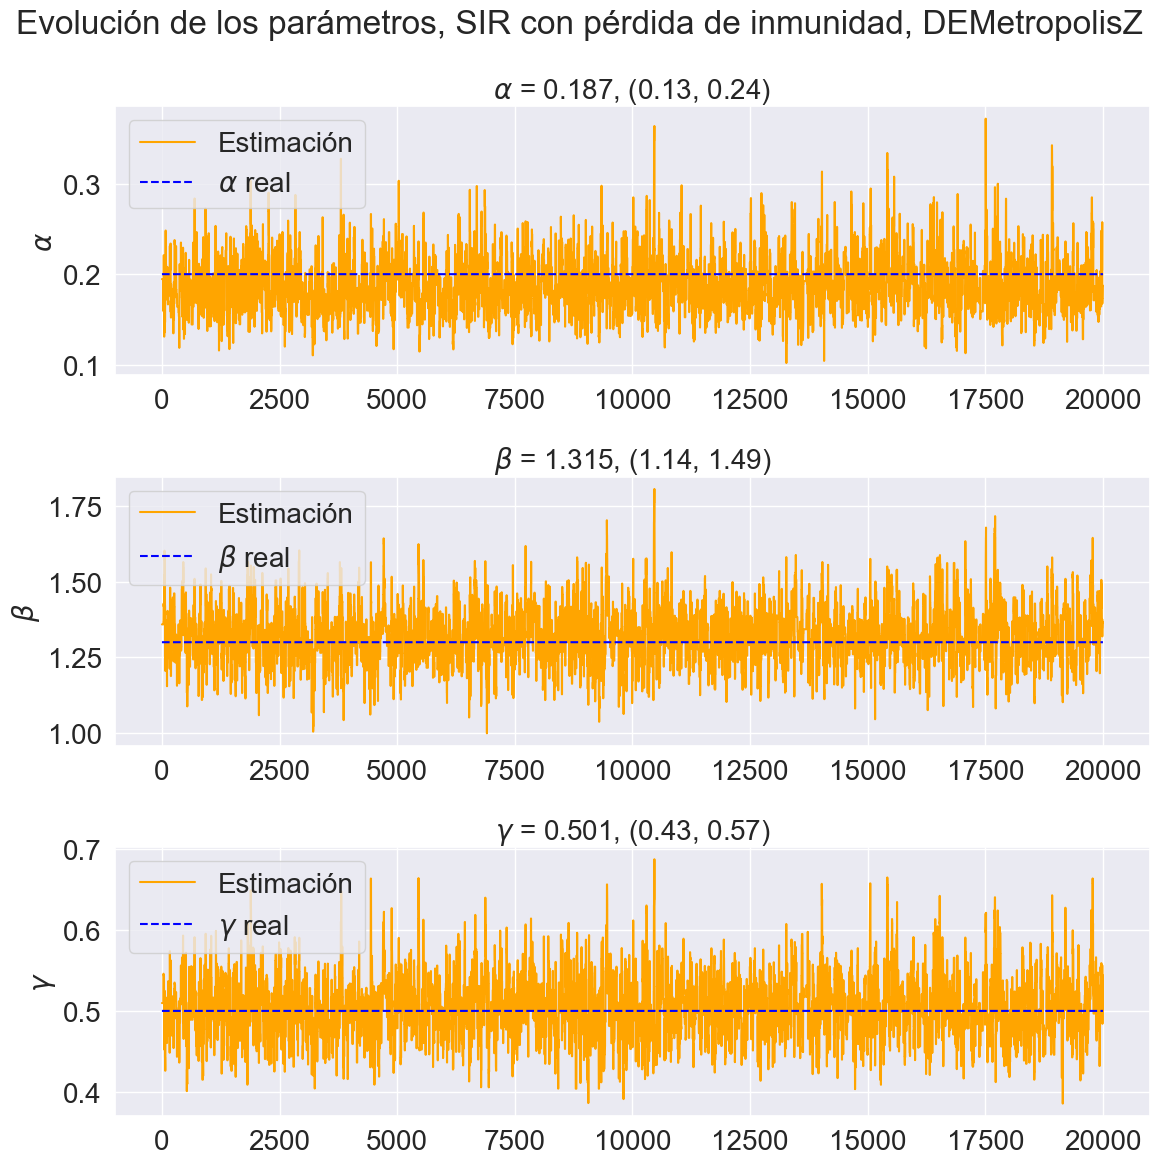

In [602]:
# Gráfico de la primera cadena a través de las iteraciones
fig, ax = plt.subplots(3, 1, figsize=(12, 12))

z1 = summ['mean']['alpha'] - 1.96*summ['sd']['alpha']
z2 = summ['mean']['alpha'] + 1.96*summ['sd']['alpha']
print(f"{'alpha'}: {summ['mean']['alpha']} ({z1}, {z2})")

ax[0].plot(trace.posterior["alpha"][0], c='orange', label='Estimación')
ax[0].plot([0.2]*len(trace.posterior["alpha"][0]), c='blue', linestyle='--', label=r'$\alpha$ real')
ax[0].set_title(r'$\alpha$ = {}, ({:.2f}, {:.2f})'.format(summ['mean']['alpha'], z1, z2))
ax[0].set_ylabel(r'$\alpha$')
ax[0].legend()

z1 = summ['mean']['beta'] - 1.96*summ['sd']['beta']
z2 = summ['mean']['beta'] + 1.96*summ['sd']['beta']
print(f"{'beta'}: {summ['mean']['beta']} ({z1}, {z2})")

ax[1].plot(trace.posterior["beta"][0], c='orange', label='Estimación')
ax[1].plot([1.3]*len(trace.posterior["beta"][0]), c='blue', linestyle='--', label=r'$\beta$ real')
ax[1].set_title(r'$\beta$ = {}, ({:.2f}, {:.2f})'.format(summ['mean']['beta'], z1, z2))
ax[1].set_ylabel(r'$\beta$')
ax[1].legend()

z1 = summ['mean']['gamma'] - 1.96*summ['sd']['gamma']
z2 = summ['mean']['gamma'] + 1.96*summ['sd']['gamma']
print(f"{'gamma'}: {summ['mean']['gamma']} ({z1}, {z2})")

ax[2].plot(trace.posterior["gamma"][0], c='orange', label='Estimación')
ax[2].plot([0.5]*len(trace.posterior["gamma"][0]), c='blue', linestyle='--', label=r'$\gamma$ real')
ax[2].set_title(r'$\gamma$ = {}, ({:.2f}, {:.2f})'.format(summ['mean']['gamma'], z1, z2))
ax[2].set_ylabel(r'$\gamma$')
ax[2].legend()

fig.suptitle('Evolución de los parámetros, SIR con pérdida de inmunidad, DEMetropolisZ')
plt.tight_layout()
plt.savefig(img_path+'DEMetropolis_sir_rec_params_trace.pdf')

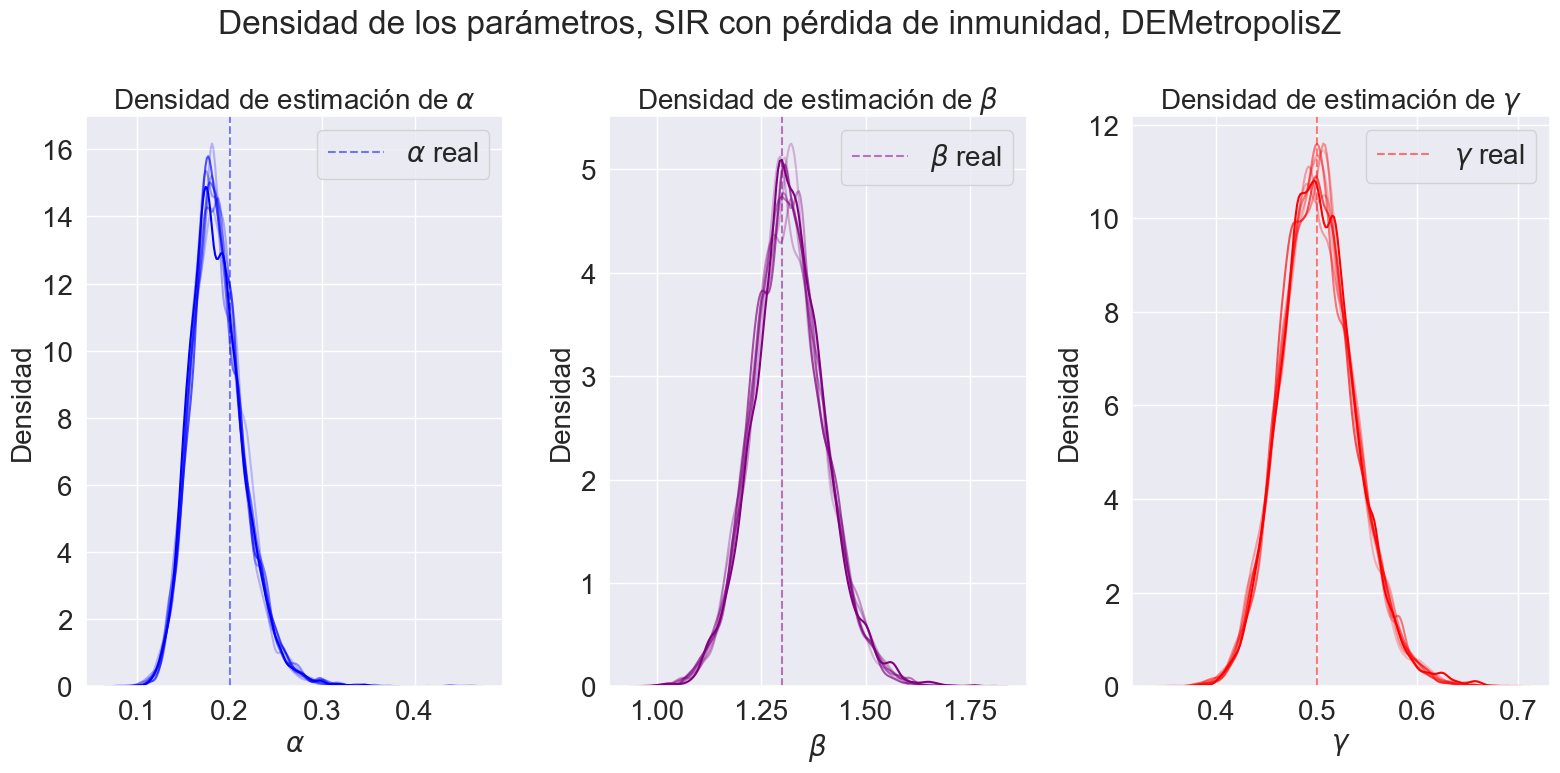

In [603]:
fig, ax = plt.subplots(1, 3, figsize=(16, 8))

for i in range(8):
    sns.kdeplot(trace.posterior["alpha"][i], ax=ax[0], color='blue', alpha=1/(i*0.5+1))
    sns.kdeplot(trace.posterior["beta"][i], ax=ax[1], color='purple', alpha=1/(i*0.5+1))
    sns.kdeplot(trace.posterior["gamma"][i], ax=ax[2], color='red', alpha=1/(i*0.5+1))

ax[0].axvline(alpha, color='blue', linestyle='--', label=r'$\alpha$ real', alpha=0.5)
ax[0].set_title(r'Densidad de estimación de $\alpha$')
ax[0].set_xlabel(r'$\alpha$')
ax[0].set_ylabel('Densidad')
ax[0].legend()

ax[1].axvline(beta, color='purple', linestyle='--', label=r'$\beta$ real', alpha=0.5)
ax[1].set_title(r'Densidad de estimación de $\beta$')
ax[1].set_xlabel(r'$\beta$')
ax[1].set_ylabel('Densidad')
ax[1].legend()

ax[2].axvline(gamma, color='red', linestyle='--', label=r'$\gamma$ real', alpha=0.5)
ax[2].set_title(r'Densidad de estimación de $\gamma$')
ax[2].set_xlabel(r'$\gamma$')
ax[2].set_ylabel('Densidad')
ax[2].legend()

fig.suptitle(r'Densidad de los parámetros, SIR con pérdida de inmunidad, DEMetropolisZ')
plt.tight_layout()
plt.savefig(img_path+'DEMetropolis_sir_rec_params_density.pdf')

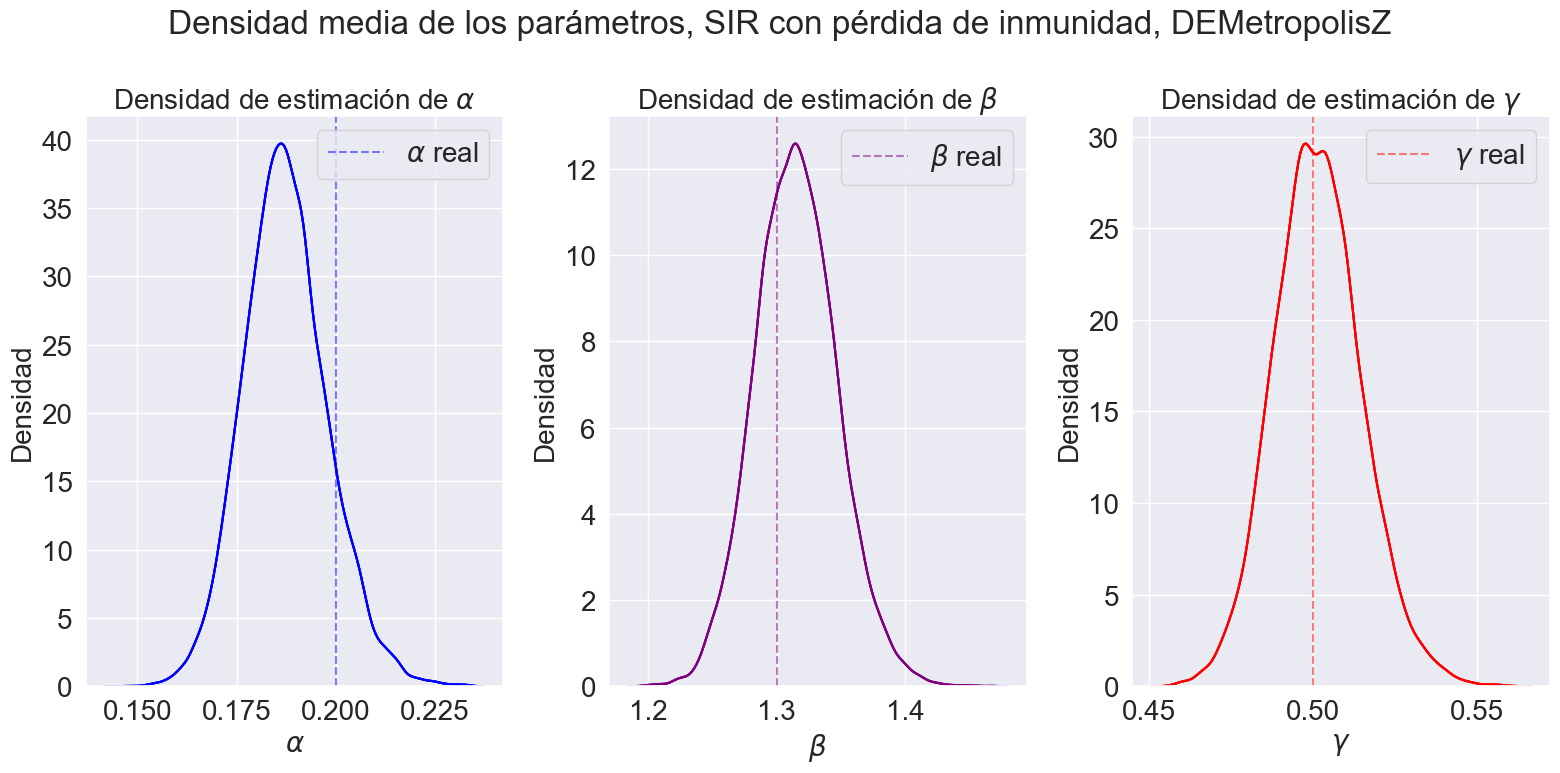

In [604]:
fig, ax = plt.subplots(1, 3, figsize=(16, 8))

for i in range(8):
    sns.kdeplot(trace.posterior["alpha"].mean(axis=0), ax=ax[0], color='blue', alpha=1/(i*0.5+1))
    sns.kdeplot(trace.posterior["beta"].mean(axis=0), ax=ax[1], color='purple', alpha=1/(i*0.5+1))
    sns.kdeplot(trace.posterior["gamma"].mean(axis=0), ax=ax[2], color='red', alpha=1/(i*0.5+1))

ax[0].axvline(alpha, color='blue', linestyle='--', label=r'$\alpha$ real', alpha=0.5)
ax[0].set_title(r'Densidad de estimación de $\alpha$')
ax[0].set_xlabel(r'$\alpha$')
ax[0].set_ylabel('Densidad')
ax[0].legend()

ax[1].axvline(beta, color='purple', linestyle='--', label=r'$\beta$ real', alpha=0.5)
ax[1].set_title(r'Densidad de estimación de $\beta$')
ax[1].set_xlabel(r'$\beta$')
ax[1].set_ylabel('Densidad')
ax[1].legend()

ax[2].axvline(gamma, color='red', linestyle='--', label=r'$\gamma$ real', alpha=0.5)
ax[2].set_title(r'Densidad de estimación de $\gamma$')
ax[2].set_xlabel(r'$\gamma$')
ax[2].set_ylabel('Densidad')
ax[2].legend()

fig.suptitle(r'Densidad media de los parámetros, SIR con pérdida de inmunidad, DEMetropolisZ')
plt.tight_layout()
plt.savefig(img_path+'DEMetropolis_sir_rec_params_density_mean.pdf')

In [605]:
np.random.seed(42)

# Dinámica con los parámetros constantes
def f(x, alpha, beta, gamma, delta):
    S, E, I, R = x
    return x + np.array([
        alpha*R-beta*S*I,
        beta*S*I - gamma*E,
        gamma*E - delta*I,
        delta*I - alpha*R
    ])

# Observación
g = lambda x: np.array([x[0], x[2]])

# Parámetros
alpha = 0.2
beta = 1.3
gamma = 0.4
delta = 0.5

# Condición inicial
x0 = np.array([0.9, 0.1, 0, 0])

# Dimensiones
nx, ny = len(x0), g(x0).shape[0]

# Covarianzas
sigma = 0.001
Q = np.diag([sigma, sigma, sigma, 1, 1])
R = sigma*np.eye(ny)

iters = 20

# Datos sintéticos
x, y = np.zeros((nx, iters)), np.zeros((ny, iters))
x[:, 0] = x0
for i in range(1, iters):
    x[:, i] = f(x[:, i-1], alpha, beta, gamma, delta)
    y[:, i] = g(x[:, i]) + np.random.multivariate_normal(np.zeros(ny), R)

In [606]:
@as_op(itypes=[pt.dvector], otypes=[pt.dmatrix])
def pytensor_forward_model_matrix(theta):
    alpha, beta, gamma, delta = theta
    x_, y_ = np.zeros((nx, iters)), np.zeros((ny, iters))
    x_[:, 0] = x0

    for i in range(1, iters):
        x_[:, i] = f(x_[:, i-1], alpha, beta, gamma, delta)
        y_[:, i] = g(x_[:, i]) + np.random.multivariate_normal(np.zeros(ny), R)

    return y_

In [607]:
theta = [0.1, 0.1, 0.1, 0.1]

with pm.Model() as model:
    # Priors
    alpha_ = pm.Uniform("alpha", 0, 1)
    beta_ = pm.Uniform("beta", 0, 2)
    gamma_ = pm.Uniform("gamma", 0, 1)
    delta_ = pm.Uniform("delta", 0, 1)
    sigma_ = pm.HalfNormal("sigma", sigma=0.1)

    # Ode solution function
    y_ = pytensor_forward_model_matrix(
        pm.math.stack([alpha_, beta_, gamma_, delta_])
    )

    # Likelihood
    pm.Normal("Y_obs", mu=y_, sigma=sigma_, observed=y)

In [608]:
np.random.seed(42)

sampler = "DEMetropolisZ"
tune = draws = 20000
time_met = time()
with model:
    trace_DEMZ = pm.sample(step=[pm.DEMetropolisZ()], tune=tune, draws=draws, chains=8, cores=8)
time_met = time() - time_met

Multiprocess sampling (8 chains in 8 jobs)
DEMetropolisZ: [alpha, beta, gamma, delta, sigma]


Output()

Sampling 8 chains for 20_000 tune and 20_000 draw iterations (160_000 + 160_000 draws total) took 2970 seconds.


In [609]:
trace = trace_DEMZ
az.summary(trace)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha  0.532  0.310   0.112    1.000      0.007    0.005    1678.0    1490.0   
beta   1.841  0.236   1.344    2.000      0.009    0.006    1105.0     725.0   
gamma  0.346  0.085   0.209    0.511      0.003    0.002    1567.0     924.0   
delta  0.659  0.096   0.465    0.830      0.003    0.002    1410.0    1093.0   
sigma  0.053  0.012   0.032    0.076      0.000    0.000    3135.0    5933.0   

       r_hat  
alpha   1.01  
beta    1.01  
gamma   1.01  
delta   1.01  
sigma   1.00

In [610]:
print(f"Tiempo de ejecución: {time_met:.2f} s")

Tiempo de ejecución: 2971.79 s


In [611]:
params = ['alpha', 'beta', 'gamma', 'delta']
summ = az.summary(trace)

print("Parámetros estimados:")
for i in range(len(params)):
    z1 = summ['mean'][params[i]] - 1.96*summ['sd'][params[i]]
    z2 = summ['mean'][params[i]] + 1.96*summ['sd'][params[i]]
    print(f"{params[i]}: {summ['mean'][params[i]]} ({z1}, {z2})")

Parámetros estimados:
alpha: 0.532 (-0.0756, 1.1396000000000002)
beta: 1.841 (1.3784399999999999, 2.30356)
gamma: 0.346 (0.17939999999999998, 0.5126)
delta: 0.659 (0.47084000000000004, 0.84716)


alpha: 0.532 (-0.0756, 1.1396000000000002)
beta: 1.841 (1.3784399999999999, 2.30356)
gamma: 0.346 (0.17939999999999998, 0.5126)
gamma: 0.346 (0.17939999999999998, 0.5126)


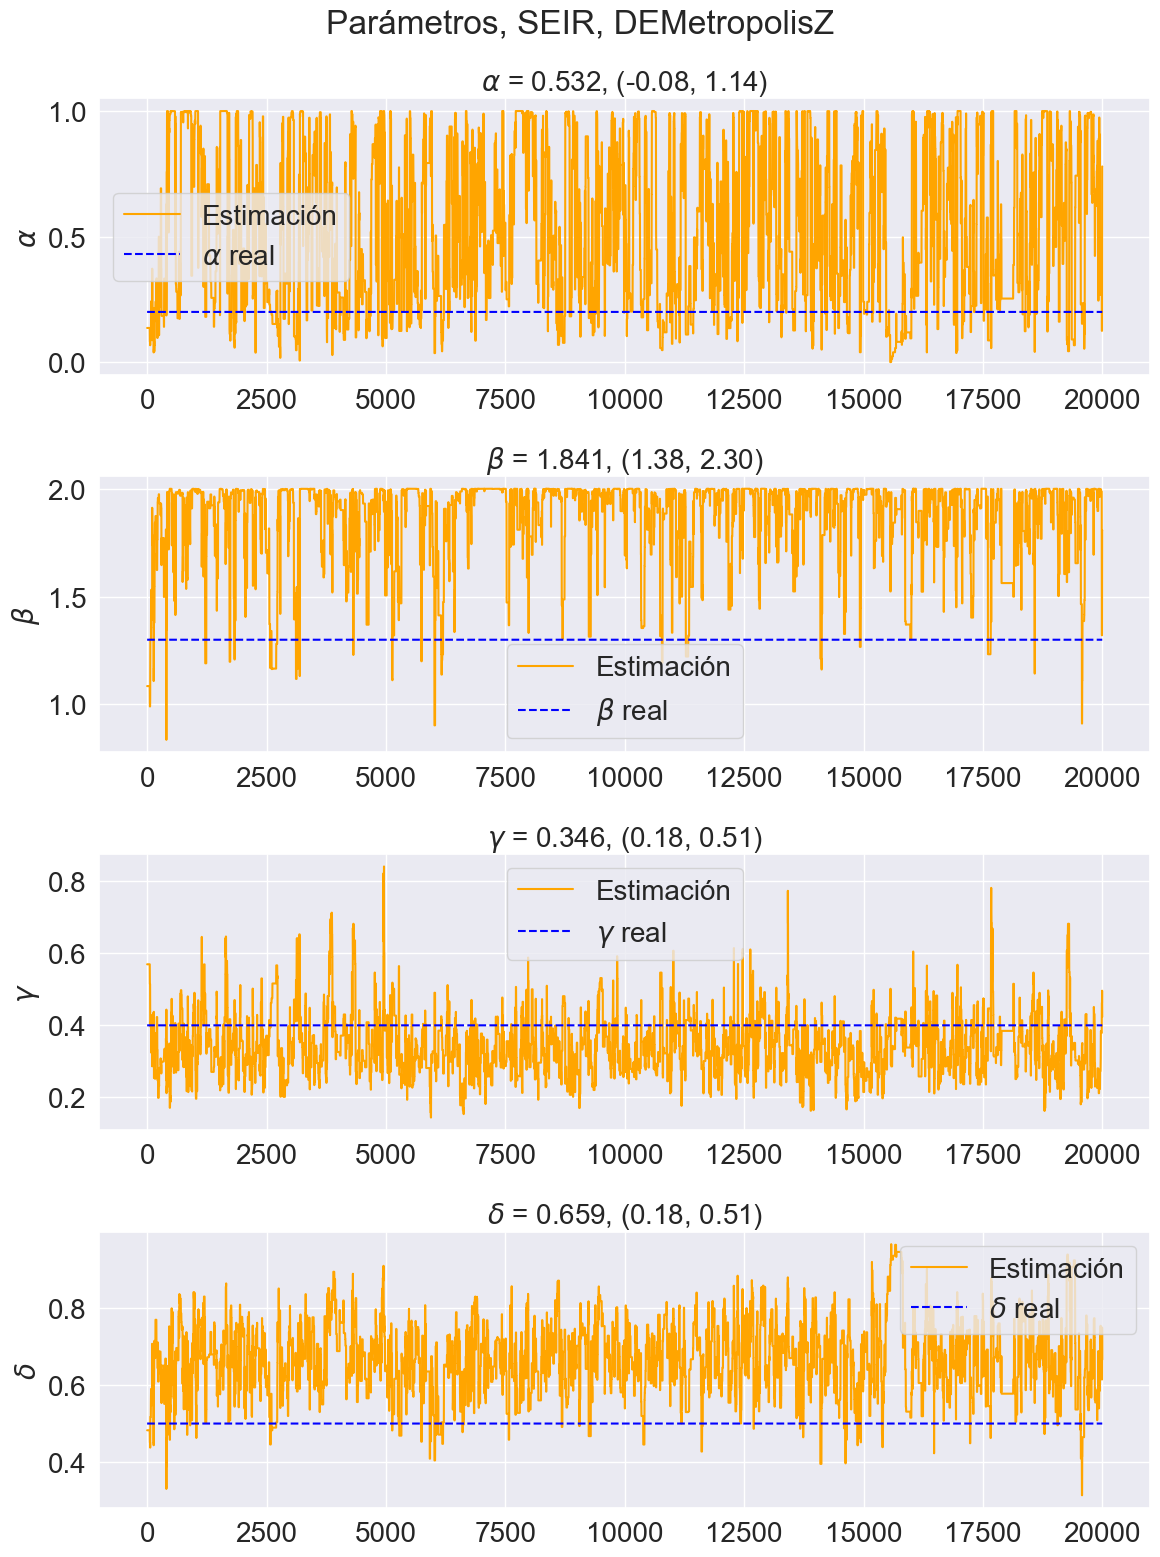

In [612]:
# Gráfico de la primera cadena a través de las iteraciones
fig, ax = plt.subplots(4, 1, figsize=(12, 16))

z1 = summ['mean']['alpha'] - 1.96*summ['sd']['alpha']
z2 = summ['mean']['alpha'] + 1.96*summ['sd']['alpha']
print(f"{'alpha'}: {summ['mean']['alpha']} ({z1}, {z2})")

ax[0].plot(trace.posterior["alpha"][0], c='orange', label='Estimación')
ax[0].plot([0.2]*len(trace.posterior["alpha"][0]), c='blue', linestyle='--', label=r'$\alpha$ real')
ax[0].set_title(r'$\alpha$ = {}, ({:.2f}, {:.2f})'.format(summ['mean']['alpha'], z1, z2))
ax[0].set_ylabel(r'$\alpha$')
ax[0].legend()

z1 = summ['mean']['beta'] - 1.96*summ['sd']['beta']
z2 = summ['mean']['beta'] + 1.96*summ['sd']['beta']
print(f"{'beta'}: {summ['mean']['beta']} ({z1}, {z2})")

ax[1].plot(trace.posterior["beta"][0], c='orange', label='Estimación')
ax[1].plot([1.3]*len(trace.posterior["beta"][0]), c='blue', linestyle='--', label=r'$\beta$ real')
ax[1].set_title(r'$\beta$ = {}, ({:.2f}, {:.2f})'.format(summ['mean']['beta'], z1, z2))
ax[1].set_ylabel(r'$\beta$')
ax[1].legend()

z1 = summ['mean']['gamma'] - 1.96*summ['sd']['gamma']
z2 = summ['mean']['gamma'] + 1.96*summ['sd']['gamma']
print(f"{'gamma'}: {summ['mean']['gamma']} ({z1}, {z2})")

ax[2].plot(trace.posterior["gamma"][0], c='orange', label='Estimación')
ax[2].plot([0.4]*len(trace.posterior["gamma"][0]), c='blue', linestyle='--', label=r'$\gamma$ real')
ax[2].set_title(r'$\gamma$ = {}, ({:.2f}, {:.2f})'.format(summ['mean']['gamma'], z1, z2))
ax[2].set_ylabel(r'$\gamma$')
ax[2].legend()

z1 = summ['mean']['gamma'] - 1.96*summ['sd']['gamma']
z2 = summ['mean']['gamma'] + 1.96*summ['sd']['gamma']
print(f"{'gamma'}: {summ['mean']['gamma']} ({z1}, {z2})")

ax[3].plot(trace.posterior["delta"][0], c='orange', label='Estimación')
ax[3].plot([0.5]*len(trace.posterior["delta"][0]), c='blue', linestyle='--', label=r'$\delta$ real')
ax[3].set_title(r'$\delta$ = {}, ({:.2f}, {:.2f})'.format(summ['mean']['delta'], z1, z2))
ax[3].set_ylabel(r'$\delta$')
ax[3].legend()

plt.suptitle('Parámetros, SEIR, DEMetropolisZ')
plt.tight_layout()
plt.savefig(img_path+'DEMetropolis_seir_params_trace.pdf')

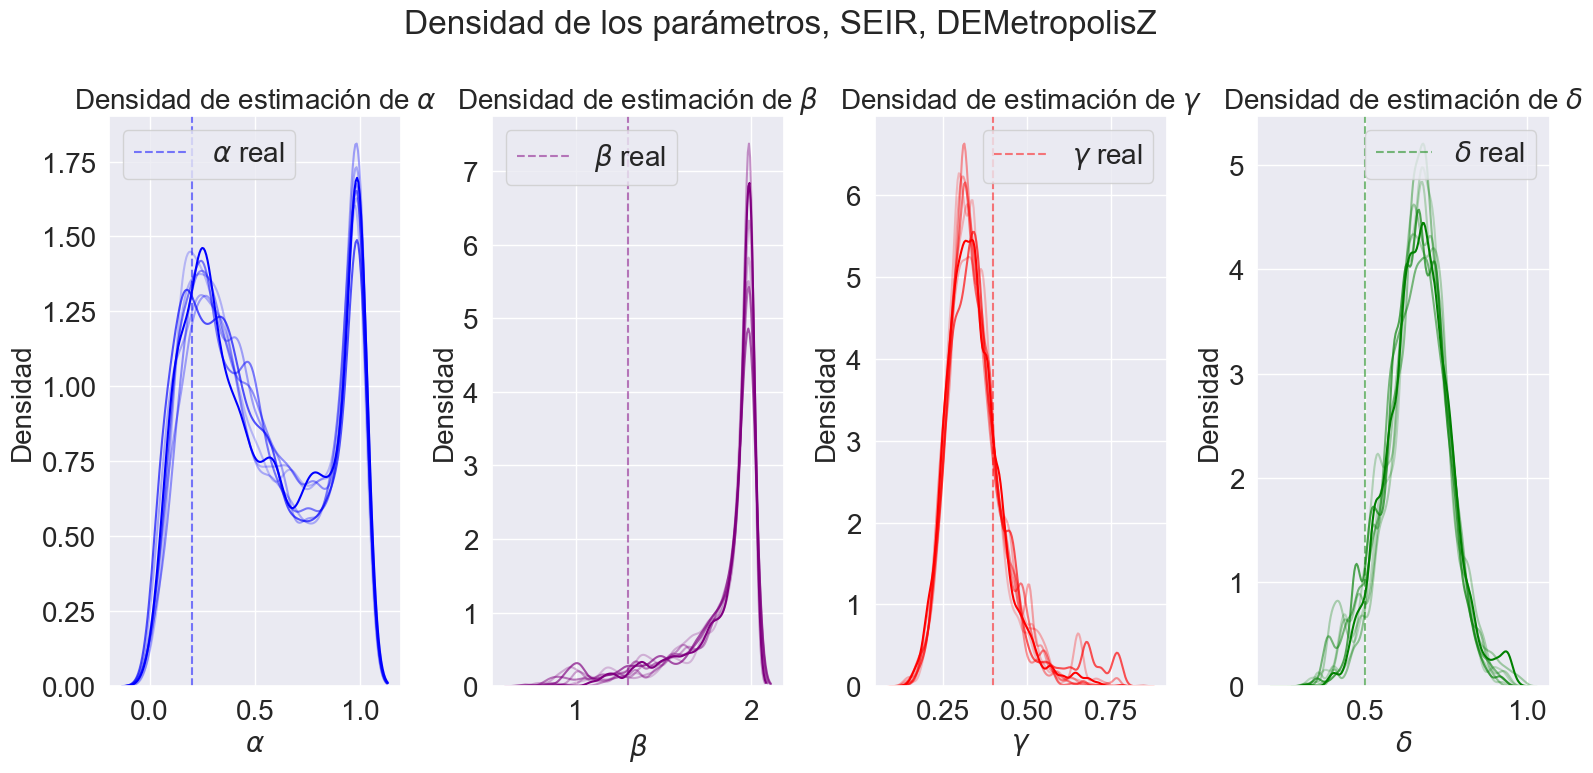

In [613]:
fig, ax = plt.subplots(1, 4, figsize=(16, 8))

for i in range(8):
    sns.kdeplot(trace.posterior["alpha"][i], ax=ax[0], color='blue', alpha=1/(i*0.5+1))
    sns.kdeplot(trace.posterior["beta"][i], ax=ax[1], color='purple', alpha=1/(i*0.5+1))
    sns.kdeplot(trace.posterior["gamma"][i], ax=ax[2], color='red', alpha=1/(i*0.5+1))
    sns.kdeplot(trace.posterior["delta"][i], ax=ax[3], color='green', alpha=1/(i*0.5+1))

ax[0].axvline(alpha, color='blue', linestyle='--', label=r'$\alpha$ real', alpha=0.5)
ax[0].set_title(r'Densidad de estimación de $\alpha$')
ax[0].set_xlabel(r'$\alpha$')
ax[0].set_ylabel('Densidad')
ax[0].legend()

ax[1].axvline(beta, color='purple', linestyle='--', label=r'$\beta$ real', alpha=0.5)
ax[1].set_title(r'Densidad de estimación de $\beta$')
ax[1].set_xlabel(r'$\beta$')
ax[1].set_ylabel('Densidad')
ax[1].legend()

ax[2].axvline(gamma, color='red', linestyle='--', label=r'$\gamma$ real', alpha=0.5)
ax[2].set_title(r'Densidad de estimación de $\gamma$')
ax[2].set_xlabel(r'$\gamma$')
ax[2].set_ylabel('Densidad')
ax[2].legend()

ax[3].axvline(delta, color='green', linestyle='--', label=r'$\delta$ real', alpha=0.5)
ax[3].set_title(r'Densidad de estimación de $\delta$')
ax[3].set_xlabel(r'$\delta$')
ax[3].set_ylabel('Densidad')
ax[3].legend()

fig.suptitle(r'Densidad de los parámetros, SEIR, DEMetropolisZ')
plt.tight_layout()
plt.savefig(img_path+'DEMetropolis_seir_params_density.pdf')

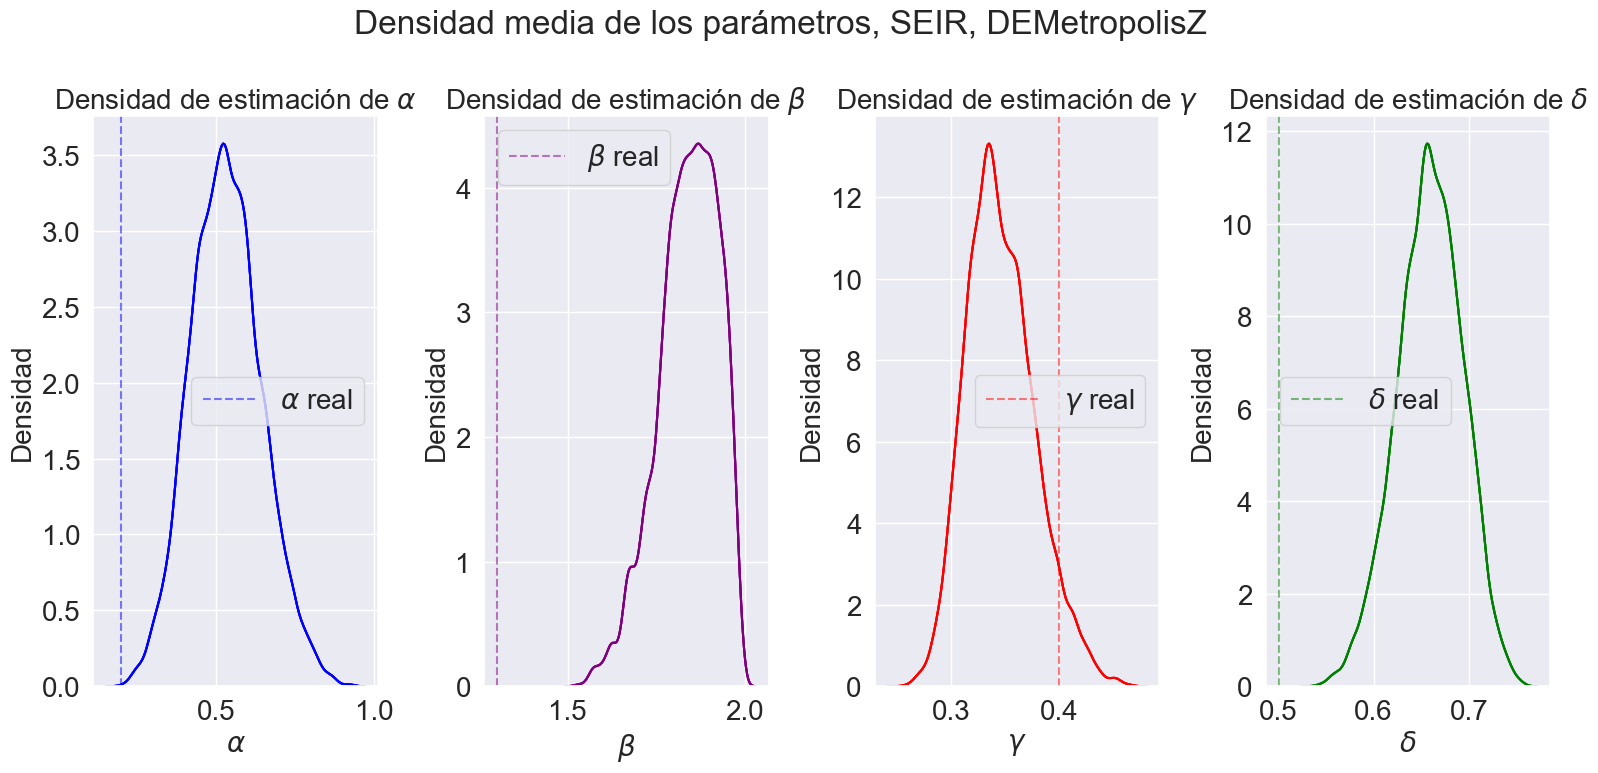

In [614]:
fig, ax = plt.subplots(1, 4, figsize=(16, 8))

for i in range(8):
    sns.kdeplot(trace.posterior["alpha"].mean(axis=0), ax=ax[0], color='blue', alpha=1/(i*0.5+1))
    sns.kdeplot(trace.posterior["beta"].mean(axis=0), ax=ax[1], color='purple', alpha=1/(i*0.5+1))
    sns.kdeplot(trace.posterior["gamma"].mean(axis=0), ax=ax[2], color='red', alpha=1/(i*0.5+1))
    sns.kdeplot(trace.posterior["delta"].mean(axis=0), ax=ax[3], color='green', alpha=1/(i*0.5+1))

ax[0].axvline(alpha, color='blue', linestyle='--', label=r'$\alpha$ real', alpha=0.5)
ax[0].set_title(r'Densidad de estimación de $\alpha$')
ax[0].set_xlabel(r'$\alpha$')
ax[0].set_ylabel('Densidad')
ax[0].legend()

ax[1].axvline(beta, color='purple', linestyle='--', label=r'$\beta$ real', alpha=0.5)
ax[1].set_title(r'Densidad de estimación de $\beta$')
ax[1].set_xlabel(r'$\beta$')
ax[1].set_ylabel('Densidad')
ax[1].legend()

ax[2].axvline(gamma, color='red', linestyle='--', label=r'$\gamma$ real', alpha=0.5)
ax[2].set_title(r'Densidad de estimación de $\gamma$')
ax[2].set_xlabel(r'$\gamma$')
ax[2].set_ylabel('Densidad')
ax[2].legend()

ax[3].axvline(delta, color='green', linestyle='--', label=r'$\delta$ real', alpha=0.5)
ax[3].set_title(r'Densidad de estimación de $\delta$')
ax[3].set_xlabel(r'$\delta$')
ax[3].set_ylabel('Densidad')
ax[3].legend()

fig.suptitle(r'Densidad media de los parámetros, SEIR, DEMetropolisZ')
plt.tight_layout()
plt.savefig(img_path+'DEMetropolis_seir_params_density_mean.pdf')

## NUTS

In [615]:
np.random.seed(42)

# Dinámica con los parámetros constantes
def f(x, beta, gamma):
    S, I, R = x
    return x + np.array([
        -beta*S*I,
        beta*S*I - gamma*I,
        gamma*I
    ])

# Observación
g = lambda x: np.array([x[0], x[1]])

# Parámetros
beta = 1.3
gamma = 0.5

# Condición inicial
x0 = np.array([0.9, 0.1, 0])

# Dimensiones
nx, ny = len(x0), g(x0).shape[0]

# Covarianzas
sigma = 0.001
Q = np.diag([sigma, sigma, sigma, 1, 1])
R = sigma*np.eye(ny)

iters = 20

# Datos sintéticos
x, y = np.zeros((nx, iters)), np.zeros((ny, iters))
x[:, 0] = x0
for i in range(1, iters):
    x[:, i] = f(x[:, i-1], beta, gamma)
    y[:, i] = g(x[:, i]) + np.random.multivariate_normal(np.zeros(ny), R)

In [616]:
def rhs_pymcode(y, t, p):
    dS_dt = -p[0]*y[0]*y[1]
    dI_dt = p[0]*y[0]*y[1] - p[1]*y[1]
    dR_dt = p[1]*y[1]
    return [dS_dt, dI_dt, dR_dt]

In [617]:
ode_model = DifferentialEquation(
    func=rhs_pymcode, times=np.arange(iters), n_states=3, n_theta=2, t0=0
)

In [618]:
with pm.Model() as model:
    # Priors
    beta = pm.Uniform("beta", lower=0, upper=2)
    gamma = pm.Uniform("gamma", lower=0, upper=1)
    sigma = pm.HalfNormal("sigma", sigma=0.1)

    # ode_solution
    ode_solution = ode_model(y0=[0.9, 0.1, 0.0], theta=[beta, gamma])[:, :2]

    # Likelihood
    pm.Normal("Y_obs", mu=ode_solution, sigma=sigma, observed=y.T)

In [619]:
np.random.seed(42)

sampler = "NUTS PyMC ODE"
tune = draws = 150
time_nuts = time()
with model:
    trace_pymc_ode = pm.sample(tune=tune, draws=draws, chains=8, cores=8)
time_nuts = time() - time_nuts

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [beta, gamma, sigma]


Output()

Sampling 8 chains for 150 tune and 150 draw iterations (1_200 + 1_200 draws total) took 1993 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [620]:
trace = trace_pymc_ode
az.summary(trace)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
beta   1.407  0.172   1.121    1.742      0.008    0.006     553.0     443.0   
gamma  0.474  0.082   0.335    0.629      0.003    0.002     686.0     713.0   
sigma  0.153  0.017   0.123    0.185      0.001    0.001     544.0     585.0   

       r_hat  
beta    1.01  
gamma   1.01  
sigma   1.01

In [621]:
print(f"Tiempo de ejecución: {time_nuts:.2f} s")

Tiempo de ejecución: 1994.05 s


In [622]:
params = ['beta', 'gamma']
summ = az.summary(trace)

print("Parámetros estimados:")
for i in range(len(params)):
    z1 = summ['mean'][params[i]] - 1.96*summ['sd'][params[i]]
    z2 = summ['mean'][params[i]] + 1.96*summ['sd'][params[i]]
    print(f"{params[i]}: {summ['mean'][params[i]]} ({z1}, {z2})")

Parámetros estimados:
beta: 1.407 (1.06988, 1.7441200000000001)
gamma: 0.474 (0.31328, 0.63472)


beta: 1.407 (1.06988, 1.7441200000000001)
gamma: 0.474 (0.31328, 0.63472)


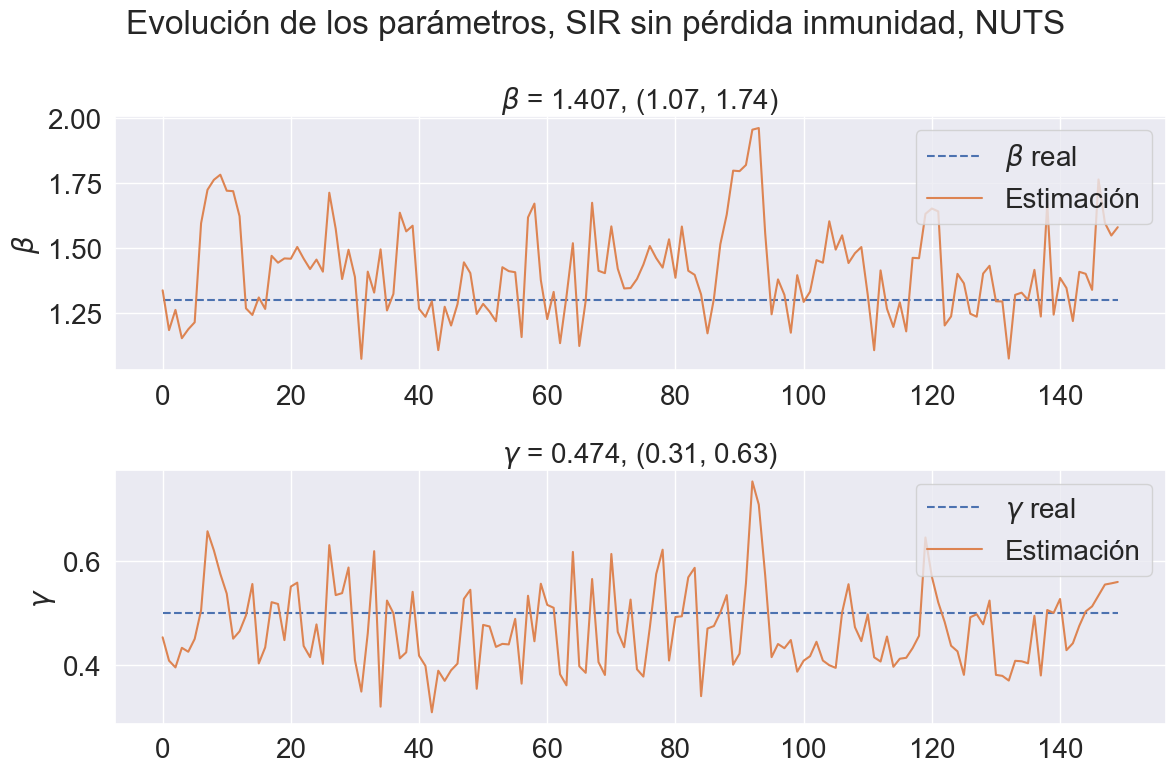

In [623]:
# Gráfico de la primera cadena a través de las iteraciones
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

z1 = summ['mean']['beta'] - 1.96*summ['sd']['beta']
z2 = summ['mean']['beta'] + 1.96*summ['sd']['beta']
print(f"{'beta'}: {summ['mean']['beta']} ({z1}, {z2})")

ax[0].plot([1.3]*len(trace.posterior["beta"][0]), linestyle='--', label=r'$\beta$ real')
ax[0].plot(trace.posterior["beta"][0], label='Estimación')
ax[0].set_title(r'$\beta$ = {}, ({:.2f}, {:.2f})'.format(summ['mean']['beta'], z1, z2))
ax[0].set_ylabel(r'$\beta$')
ax[0].legend()

z1 = summ['mean']['gamma'] - 1.96*summ['sd']['gamma']
z2 = summ['mean']['gamma'] + 1.96*summ['sd']['gamma']
print(f"{'gamma'}: {summ['mean']['gamma']} ({z1}, {z2})")

ax[1].plot([0.5]*len(trace.posterior["gamma"][0]), linestyle='--', label=r'$\gamma$ real')
ax[1].plot(trace.posterior["gamma"][0], label='Estimación')
ax[1].set_title(r'$\gamma$ = {}, ({:.2f}, {:.2f})'.format(summ['mean']['gamma'], z1, z2))
ax[1].set_ylabel(r'$\gamma$')
ax[1].legend()

fig.suptitle('Evolución de los parámetros, SIR sin pérdida inmunidad, NUTS')
plt.tight_layout()
plt.savefig(img_path+'NUTS_sir_params_trace.pdf')

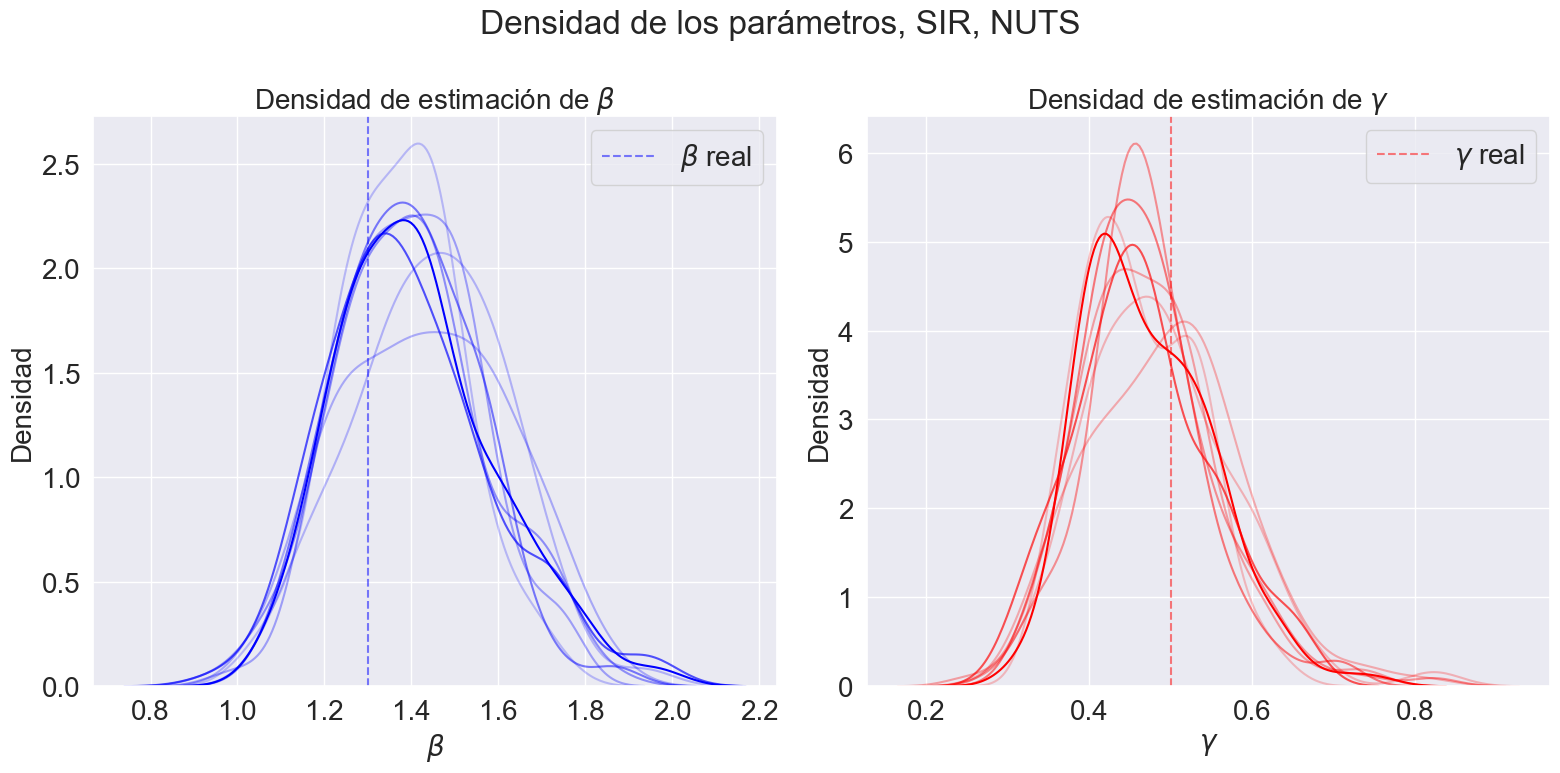

In [624]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

for i in range(8):
    sns.kdeplot(trace.posterior["beta"][i], ax=ax[0], color='blue', alpha=1/(i*0.5+1))
    sns.kdeplot(trace.posterior["gamma"][i], ax=ax[1], color='red', alpha=1/(i*0.5+1))

ax[0].axvline(1.3, color='blue', linestyle='--', label=r'$\beta$ real', alpha=0.5)
ax[0].set_title(r'Densidad de estimación de $\beta$')
ax[0].set_xlabel(r'$\beta$')
ax[0].set_ylabel('Densidad')
ax[0].legend()

ax[1].axvline(0.5, color='red', linestyle='--', label=r'$\gamma$ real', alpha=0.5)
ax[1].set_title(r'Densidad de estimación de $\gamma$')
ax[1].set_xlabel(r'$\gamma$')
ax[1].set_ylabel('Densidad')
ax[1].legend()

fig.suptitle(r'Densidad de los parámetros, SIR, NUTS')
plt.tight_layout()
plt.savefig(img_path+'NUTS_sir_params_density.pdf')

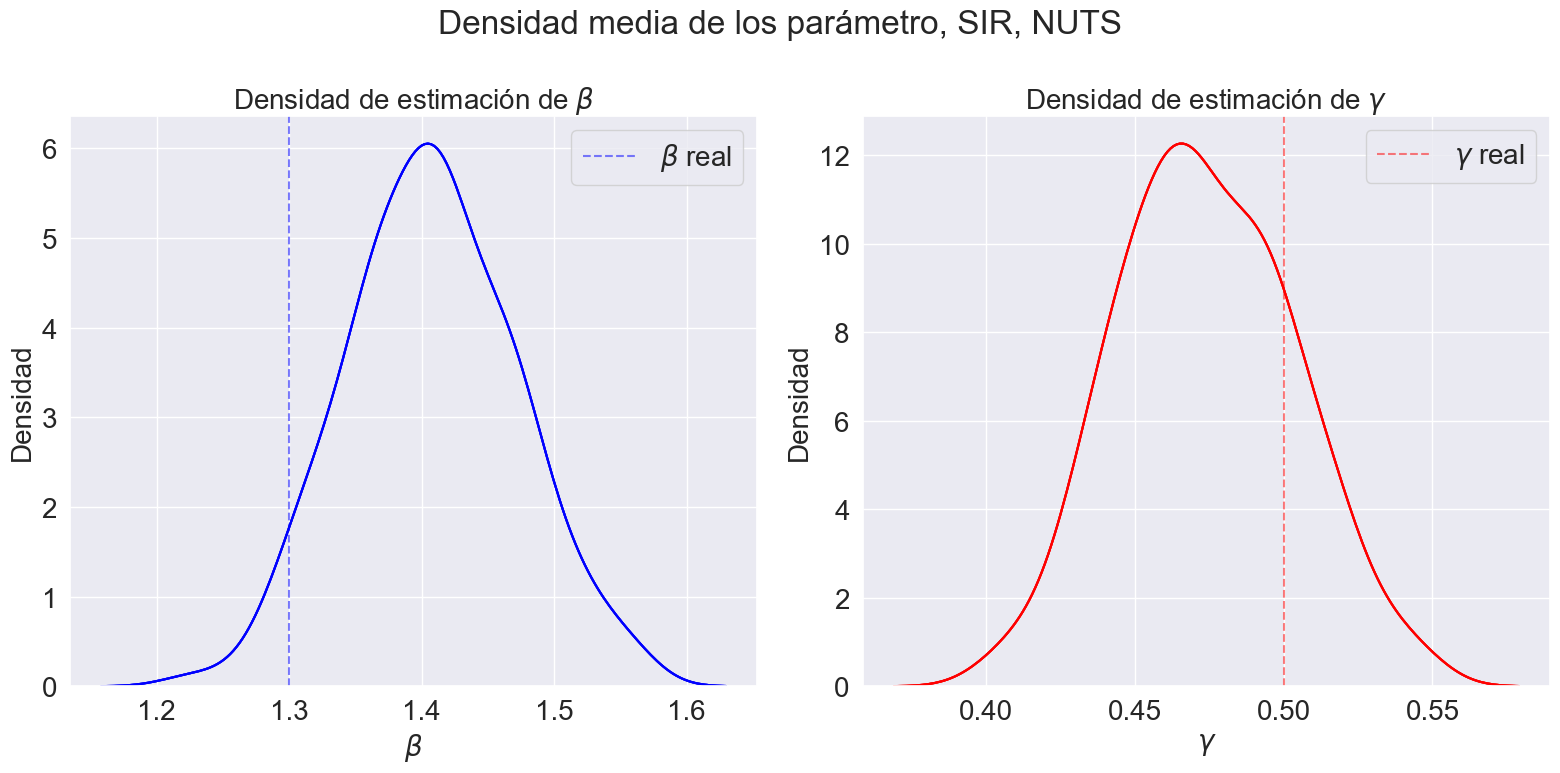

In [625]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

for i in range(8):
    sns.kdeplot(trace.posterior["beta"].mean(axis=0), ax=ax[0], color='blue', alpha=1/(i*0.5+1))
    sns.kdeplot(trace.posterior["gamma"].mean(axis=0), ax=ax[1], color='red', alpha=1/(i*0.5+1))

ax[0].axvline(1.3, color='blue', linestyle='--', label=r'$\beta$ real', alpha=0.5)
ax[0].set_title(r'Densidad de estimación de $\beta$')
ax[0].set_xlabel(r'$\beta$')
ax[0].set_ylabel('Densidad')
ax[0].legend()

ax[1].axvline(0.5, color='red', linestyle='--', label=r'$\gamma$ real', alpha=0.5)
ax[1].set_title(r'Densidad de estimación de $\gamma$')
ax[1].set_xlabel(r'$\gamma$')
ax[1].set_ylabel('Densidad')
ax[1].legend()

fig.suptitle(r'Densidad media de los parámetro, SIR, NUTS')
plt.tight_layout()
plt.savefig(img_path+'NUTS_sir_params_density_mean.pdf')

In [626]:
np.random.seed(42)

# Dinámica con los parámetros constantes
def f(x, alpha, beta, gamma):
    S, I, R = x
    return x + np.array([
        alpha*R-beta*S*I,
        beta*S*I - gamma*I,
        gamma*I - alpha*R
    ])

# Observación
g = lambda x: np.array([x[0], x[1]])

# Parámetros
alpha = 0.2
beta = 1.3
gamma = 0.5

# Condición inicial
x0 = np.array([0.9, 0.1, 0])

# Dimensiones
nx, ny = len(x0), g(x0).shape[0]

# Covarianzas
sigma = 0.001
Q = np.diag([sigma, sigma, sigma, 1, 1])
R = sigma*np.eye(ny)

iters = 20

# Datos sintéticos
x, y = np.zeros((nx, iters)), np.zeros((ny, iters))
x[:, 0] = x0
for i in range(1, iters):
    x[:, i] = f(x[:, i-1], alpha, beta, gamma)
    y[:, i] = g(x[:, i]) + np.random.multivariate_normal(np.zeros(ny), R)

In [627]:
def rhs_pymcode(y, t, p):
    dS_dt = p[0]*y[2]-p[1]*y[0]*y[1]
    dI_dt = p[1]*y[0]*y[1] - p[2]*y[1]
    dR_dt = p[2]*y[1]-p[0]*y[2]
    return [dS_dt, dI_dt, dR_dt]

In [628]:
ode_model = DifferentialEquation(
    func=rhs_pymcode, times=np.arange(iters), n_states=3, n_theta=3, t0=0
)

In [629]:
theta = [0.1, 0.1, 0.1]

with pm.Model() as model:
    # Priors
    alpha = pm.Uniform("alpha", 0, 1)
    beta = pm.Uniform("beta", 0, 2)
    gamma = pm.Uniform("gamma", 0, 1)
    sigma = pm.HalfNormal("sigma", sigma=0.1)

    # ode_solution
    ode_solution = ode_model(y0=[0.9, 0.1, 0.0], theta=[alpha, beta, gamma])[:, :2]

    # Likelihood
    pm.Normal("Y_obs", mu=ode_solution, sigma=sigma, observed=y.T)

In [630]:
np.random.seed(42)

sampler = "NUTS PyMC ODE"
tune = draws = 150
time_nuts = time()
with model:
    trace_pymc_ode = pm.sample(tune=tune, draws=draws, chains=8, cores=8)
time_nuts = time() - time_nuts

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [alpha, beta, gamma, sigma]


Output()

Sampling 8 chains for 150 tune and 150 draw iterations (1_200 + 1_200 draws total) took 4069 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [631]:
trace = trace_pymc_ode
az.summary(trace)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha  0.212  0.078   0.075    0.353      0.004    0.003     376.0     595.0   
beta   1.452  0.225   1.066    1.916      0.013    0.009     320.0     209.0   
gamma  0.562  0.095   0.396    0.745      0.005    0.004     332.0     253.0   
sigma  0.154  0.016   0.123    0.183      0.001    0.000     643.0     702.0   

       r_hat  
alpha   1.02  
beta    1.02  
gamma   1.02  
sigma   1.01

In [632]:
print(f"Tiempo de ejecución: {time_nuts:.2f} s")

Tiempo de ejecución: 4070.33 s


In [633]:
params = ['alpha', 'beta', 'gamma']
summ = az.summary(trace)

print("Parámetros estimados:")
for i in range(len(params)):
    z1 = summ['mean'][params[i]] - 1.96*summ['sd'][params[i]]
    z2 = summ['mean'][params[i]] + 1.96*summ['sd'][params[i]]
    print(f"{params[i]}: {summ['mean'][params[i]]} ({z1}, {z2})")

Parámetros estimados:
alpha: 0.212 (0.059120000000000006, 0.36488)
beta: 1.452 (1.011, 1.893)
gamma: 0.562 (0.3758, 0.7482000000000001)


alpha: 0.212 (0.059120000000000006, 0.36488)
beta: 1.452 (1.011, 1.893)
gamma: 0.562 (0.3758, 0.7482000000000001)


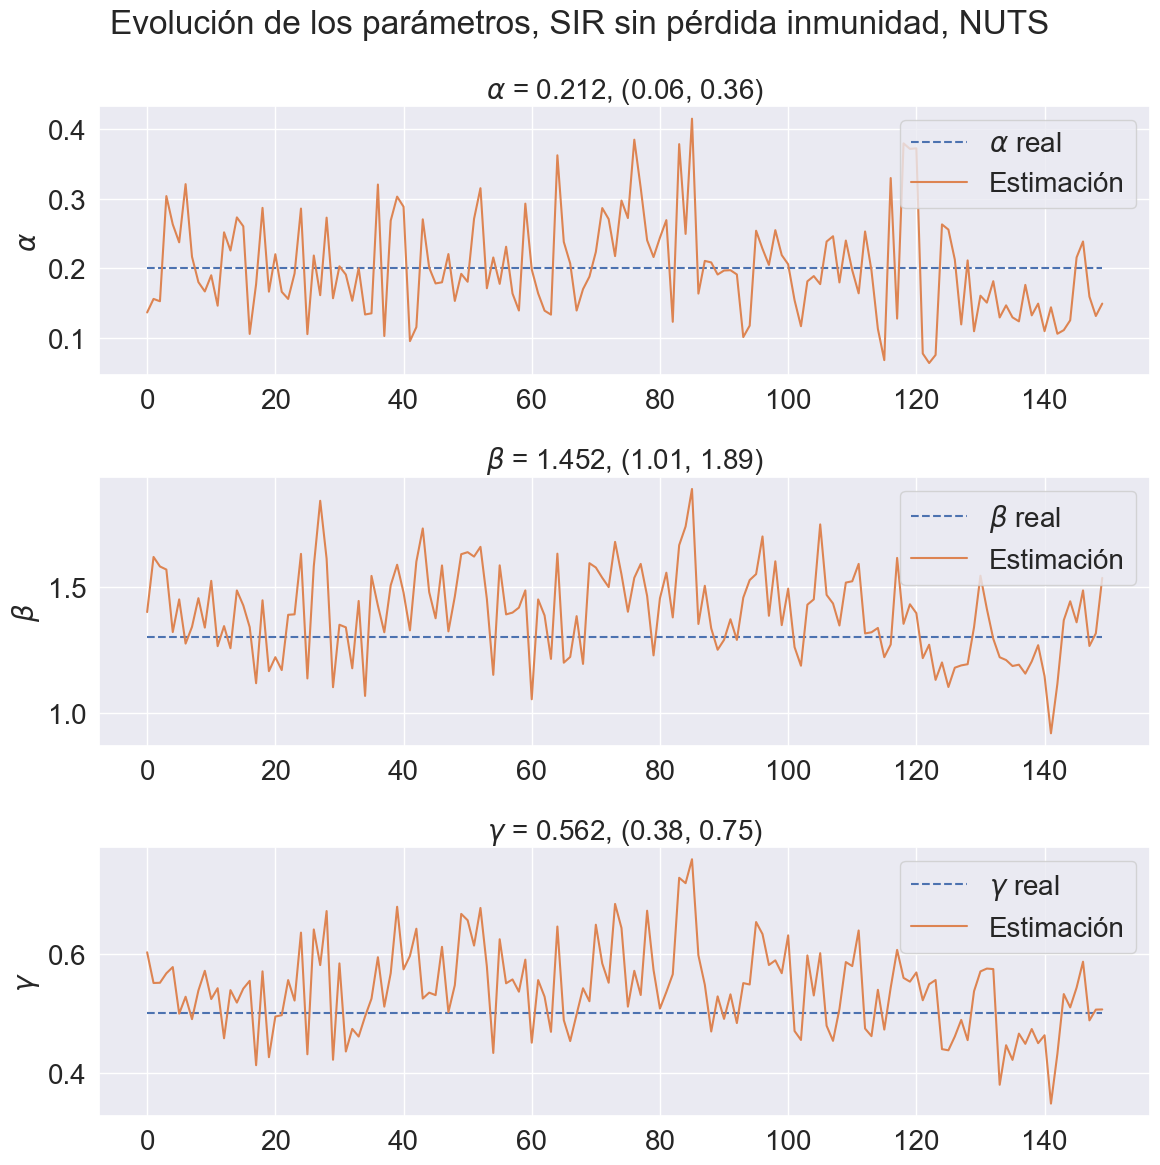

In [634]:
# Gráfico de la primera cadena a través de las iteraciones
fig, ax = plt.subplots(3, 1, figsize=(12, 12))

z1 = summ['mean']['alpha'] - 1.96*summ['sd']['alpha']
z2 = summ['mean']['alpha'] + 1.96*summ['sd']['alpha']
print(f"{'alpha'}: {summ['mean']['alpha']} ({z1}, {z2})")

ax[0].plot([0.2]*len(trace.posterior["alpha"][0]), linestyle='--', label=r'$\alpha$ real')
ax[0].plot(trace.posterior["alpha"][0], label='Estimación')
ax[0].set_title(r'$\alpha$ = {}, ({:.2f}, {:.2f})'.format(summ['mean']['alpha'], z1, z2))
ax[0].set_ylabel(r'$\alpha$')
ax[0].legend()

z1 = summ['mean']['beta'] - 1.96*summ['sd']['beta']
z2 = summ['mean']['beta'] + 1.96*summ['sd']['beta']
print(f"{'beta'}: {summ['mean']['beta']} ({z1}, {z2})")

ax[1].plot([1.3]*len(trace.posterior["beta"][0]), linestyle='--', label=r'$\beta$ real')
ax[1].plot(trace.posterior["beta"][0], label='Estimación')
ax[1].set_title(r'$\beta$ = {}, ({:.2f}, {:.2f})'.format(summ['mean']['beta'], z1, z2))
ax[1].set_ylabel(r'$\beta$')
ax[1].legend()

z1 = summ['mean']['gamma'] - 1.96*summ['sd']['gamma']
z2 = summ['mean']['gamma'] + 1.96*summ['sd']['gamma']
print(f"{'gamma'}: {summ['mean']['gamma']} ({z1}, {z2})")

ax[2].plot([0.5]*len(trace.posterior["gamma"][0]), linestyle='--', label=r'$\gamma$ real')
ax[2].plot(trace.posterior["gamma"][0], label='Estimación')
ax[2].set_title(r'$\gamma$ = {}, ({:.2f}, {:.2f})'.format(summ['mean']['gamma'], z1, z2))
ax[2].set_ylabel(r'$\gamma$')
ax[2].legend()

fig.suptitle('Evolución de los parámetros, SIR sin pérdida inmunidad, NUTS')
plt.tight_layout()
plt.savefig(img_path+'NUTS_sir_rec_params_trace.pdf')

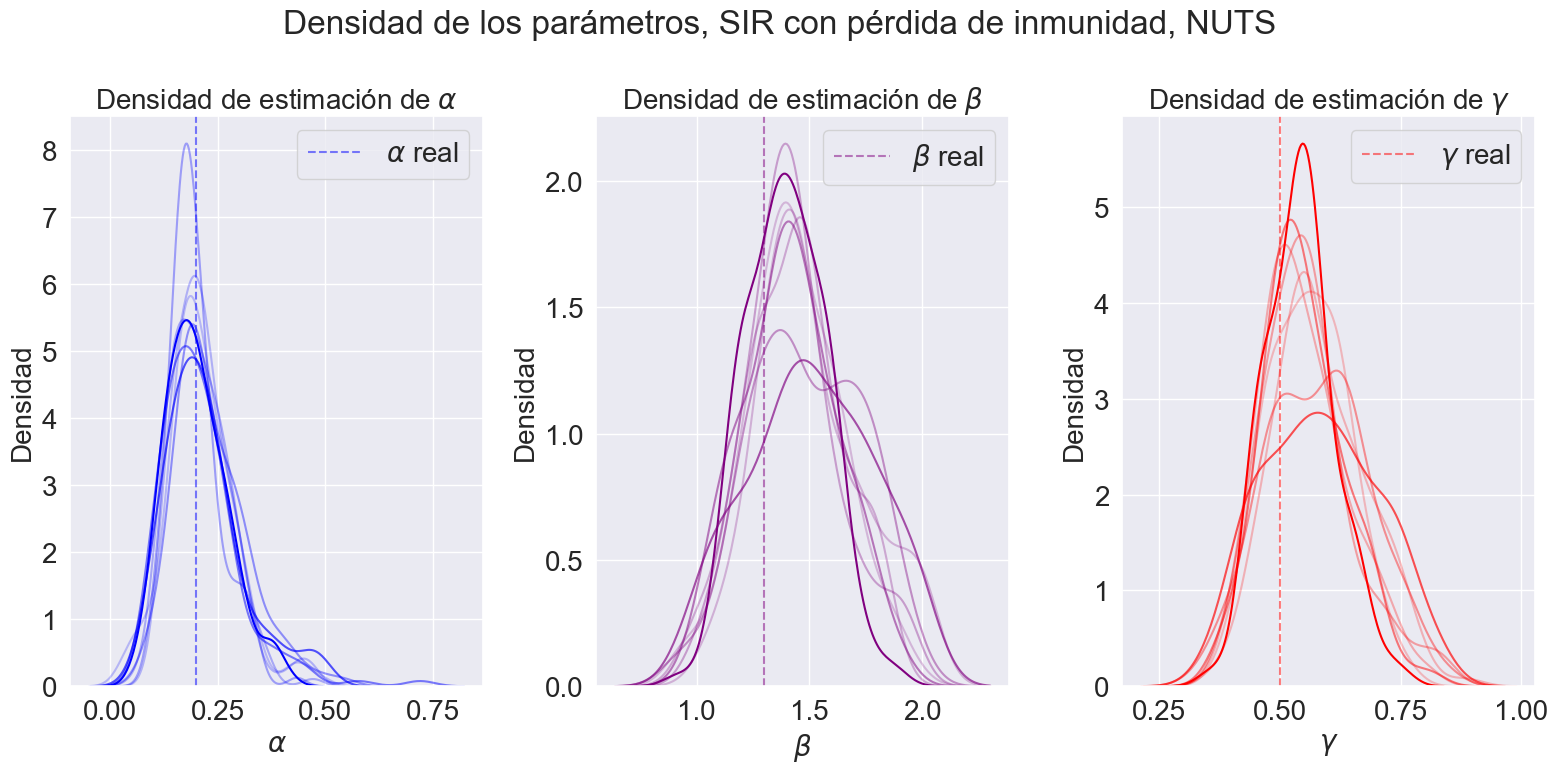

In [635]:
fig, ax = plt.subplots(1, 3, figsize=(16, 8))

for i in range(8):
    sns.kdeplot(trace.posterior["alpha"][i], ax=ax[0], color='blue', alpha=1/(i*0.5+1))
    sns.kdeplot(trace.posterior["beta"][i], ax=ax[1], color='purple', alpha=1/(i*0.5+1))
    sns.kdeplot(trace.posterior["gamma"][i], ax=ax[2], color='red', alpha=1/(i*0.5+1))

ax[0].axvline(0.2, color='blue', linestyle='--', label=r'$\alpha$ real', alpha=0.5)
ax[0].set_title(r'Densidad de estimación de $\alpha$')
ax[0].set_xlabel(r'$\alpha$')
ax[0].set_ylabel('Densidad')
ax[0].legend()

ax[1].axvline(1.3, color='purple', linestyle='--', label=r'$\beta$ real', alpha=0.5)
ax[1].set_title(r'Densidad de estimación de $\beta$')
ax[1].set_xlabel(r'$\beta$')
ax[1].set_ylabel('Densidad')
ax[1].legend()

ax[2].axvline(0.5, color='red', linestyle='--', label=r'$\gamma$ real', alpha=0.5)
ax[2].set_title(r'Densidad de estimación de $\gamma$')
ax[2].set_xlabel(r'$\gamma$')
ax[2].set_ylabel('Densidad')
ax[2].legend()

fig.suptitle(r'Densidad de los parámetros, SIR con pérdida de inmunidad, NUTS')
plt.tight_layout()
plt.savefig(img_path+'NUTS_sir_rec_params_density_mean.pdf')

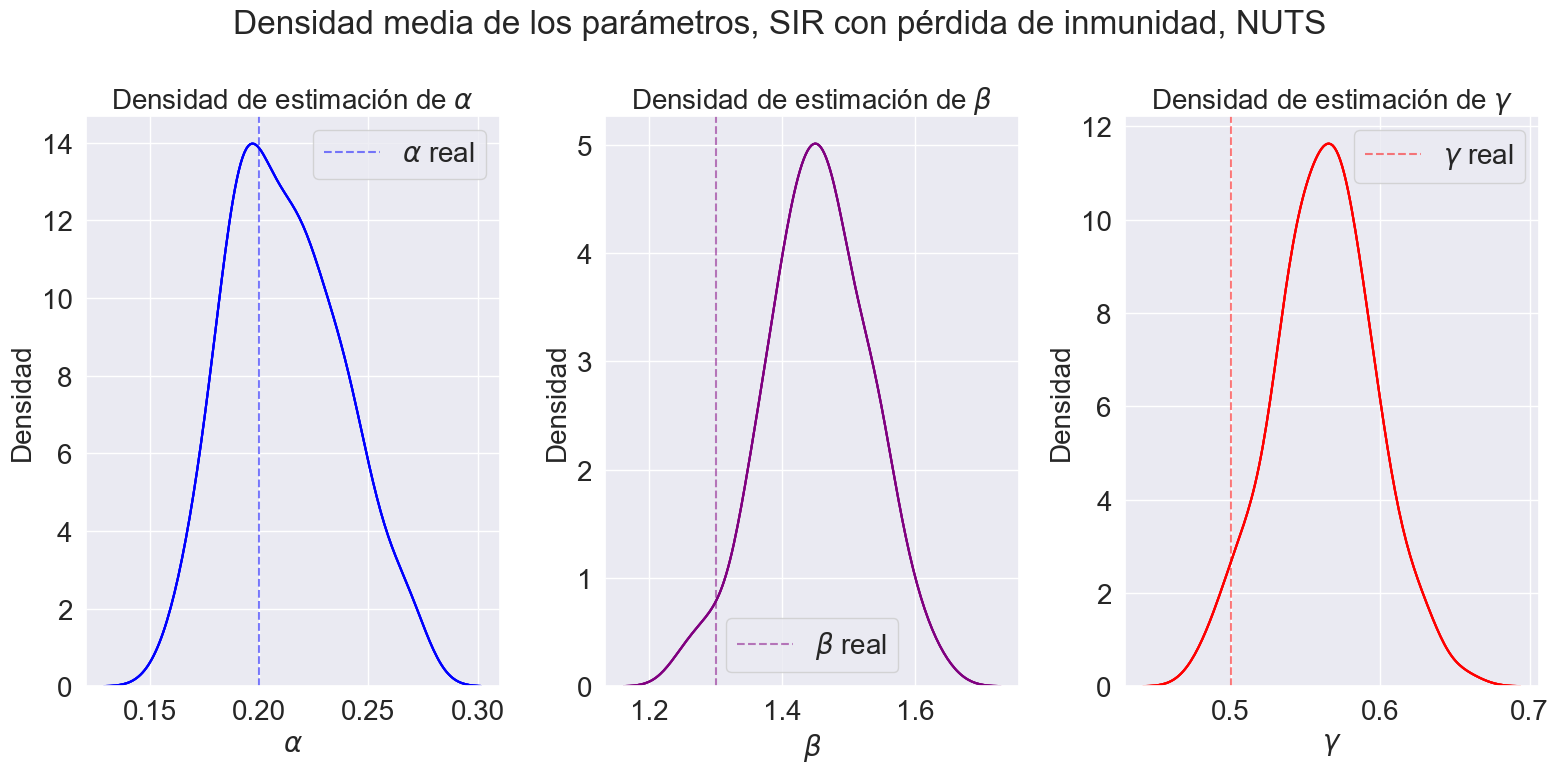

In [636]:
fig, ax = plt.subplots(1, 3, figsize=(16, 8))

for i in range(8):
    sns.kdeplot(trace.posterior["alpha"].mean(axis=0), ax=ax[0], color='blue', alpha=1/(i*0.5+1))
    sns.kdeplot(trace.posterior["beta"].mean(axis=0), ax=ax[1], color='purple', alpha=1/(i*0.5+1))
    sns.kdeplot(trace.posterior["gamma"].mean(axis=0), ax=ax[2], color='red', alpha=1/(i*0.5+1))

ax[0].axvline(0.2, color='blue', linestyle='--', label=r'$\alpha$ real', alpha=0.5)
ax[0].set_title(r'Densidad de estimación de $\alpha$')
ax[0].set_xlabel(r'$\alpha$')
ax[0].set_ylabel('Densidad')
ax[0].legend()

ax[1].axvline(1.3, color='purple', linestyle='--', label=r'$\beta$ real', alpha=0.5)
ax[1].set_title(r'Densidad de estimación de $\beta$')
ax[1].set_xlabel(r'$\beta$')
ax[1].set_ylabel('Densidad')
ax[1].legend()

ax[2].axvline(0.5, color='red', linestyle='--', label=r'$\gamma$ real', alpha=0.5)
ax[2].set_title(r'Densidad de estimación de $\gamma$')
ax[2].set_xlabel(r'$\gamma$')
ax[2].set_ylabel('Densidad')
ax[2].legend()

fig.suptitle(r'Densidad media de los parámetros, SIR con pérdida de inmunidad, NUTS')
plt.tight_layout()
plt.savefig(img_path+'NUTS_sir_rec_params_density.pdf')

## SEIR

In [637]:
np.random.seed(42)

# Dinámica con los parámetros constantes
def f(x, alpha, beta, gamma, delta):
    S, E, I, R = x
    return x + np.array([
        alpha*R-beta*S*I,
        beta*S*I - gamma*E,
        gamma*E - delta*I,
        delta*I - alpha*R
    ])

# Observación
g = lambda x: np.array([x[0], x[2]])

# Parámetros
alpha = 0.2
beta = 1.3
gamma = 0.4
delta = 0.5

# Condición inicial
x0 = np.array([0.9, 0.1, 0, 0])

# Dimensiones
nx, ny = len(x0), g(x0).shape[0]

# Covarianzas
sigma = 0.001
Q = np.diag([sigma, sigma, sigma, 1, 1])
R = sigma*np.eye(ny)

iters = 20

# Datos sintéticos
x, y = np.zeros((nx, iters)), np.zeros((ny, iters))
x[:, 0] = x0
for i in range(1, iters):
    x[:, i] = f(x[:, i-1], alpha, beta, gamma, delta)
    y[:, i] = g(x[:, i]) + np.random.multivariate_normal(np.zeros(ny), R)

def rhs_pymcode(y, t, p):
    dS_dt = p[0]*y[3]-p[1]*y[0]*y[2]
    dE_dt = p[1]*y[0]*y[2] - p[2]*y[1]
    dI_dt = p[2]*y[1] - p[3]*y[2]
    dR_dt = p[3]*y[2]-p[0]*y[3]
    return [dS_dt, dE_dt, dI_dt, dR_dt]

ode_model = DifferentialEquation(
    func=rhs_pymcode, times=np.arange(iters), n_states=4, n_theta=4, t0=0
)

theta = [0.1, 0.1, 0.1, 0.1]

with pm.Model() as model:
    # Priors
    alpha = pm.Uniform("alpha", 0, 1)
    beta = pm.Uniform("beta", 0, 2)
    gamma = pm.Uniform("gamma", 0, 1)
    delta = pm.Uniform("delta", 0, 1)
    sigma = pm.HalfNormal("sigma", sigma=0.1)

    # ode_solution
    ode_solution = ode_model(y0=[0.9, 0.1, 0.0, 0.0], theta=[alpha, beta, gamma, delta])[:, [0, 2]]

    # Likelihood
    pm.Normal("Y_obs", mu=ode_solution, sigma=sigma, observed=y.T)

In [638]:
np.random.seed(42)

sampler = "NUTS PyMC ODE"
tune = draws = 150
time_nuts = time()
with model:
    trace_pymc_ode = pm.sample(tune=tune, draws=draws, chains=8, cores=8)
time_nuts = time() - time_nuts

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [alpha, beta, gamma, delta, sigma]


Output()

Sampling 8 chains for 150 tune and 150 draw iterations (1_200 + 1_200 draws total) took 2324 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [639]:
trace = trace_pymc_ode
az.summary(trace)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha  0.404  0.266   0.002    0.878      0.011    0.007     665.0     792.0   
beta   1.566  0.308   1.015    2.000      0.017    0.012     359.0     327.0   
gamma  0.396  0.150   0.154    0.677      0.008    0.006     425.0     316.0   
delta  0.574  0.130   0.313    0.791      0.006    0.004     446.0     419.0   
sigma  0.152  0.019   0.119    0.187      0.001    0.001     560.0     425.0   

       r_hat  
alpha   1.00  
beta    1.01  
gamma   1.02  
delta   1.01  
sigma   1.02

In [640]:
print(f"Tiempo de ejecución: {time_nuts:.2f} s")

Tiempo de ejecución: 2325.63 s


In [641]:
params = ['alpha', 'beta', 'gamma', 'delta']
summ = az.summary(trace)

print("Parámetros estimados:")
for i in range(len(params)):
    z1 = summ['mean'][params[i]] - 1.96*summ['sd'][params[i]]
    z2 = summ['mean'][params[i]] + 1.96*summ['sd'][params[i]]
    print(f"{params[i]}: {summ['mean'][params[i]]} ({z1}, {z2})")

Parámetros estimados:
alpha: 0.404 (-0.11736000000000002, 0.9253600000000001)
beta: 1.566 (0.9623200000000001, 2.16968)
gamma: 0.396 (0.10200000000000004, 0.69)
delta: 0.574 (0.31919999999999993, 0.8288)


alpha: 0.404 (-0.11736000000000002, 0.9253600000000001)
beta: 1.566 (0.9623200000000001, 2.16968)
gamma: 0.396 (0.10200000000000004, 0.69)
delta: 0.574 (0.31919999999999993, 0.8288)


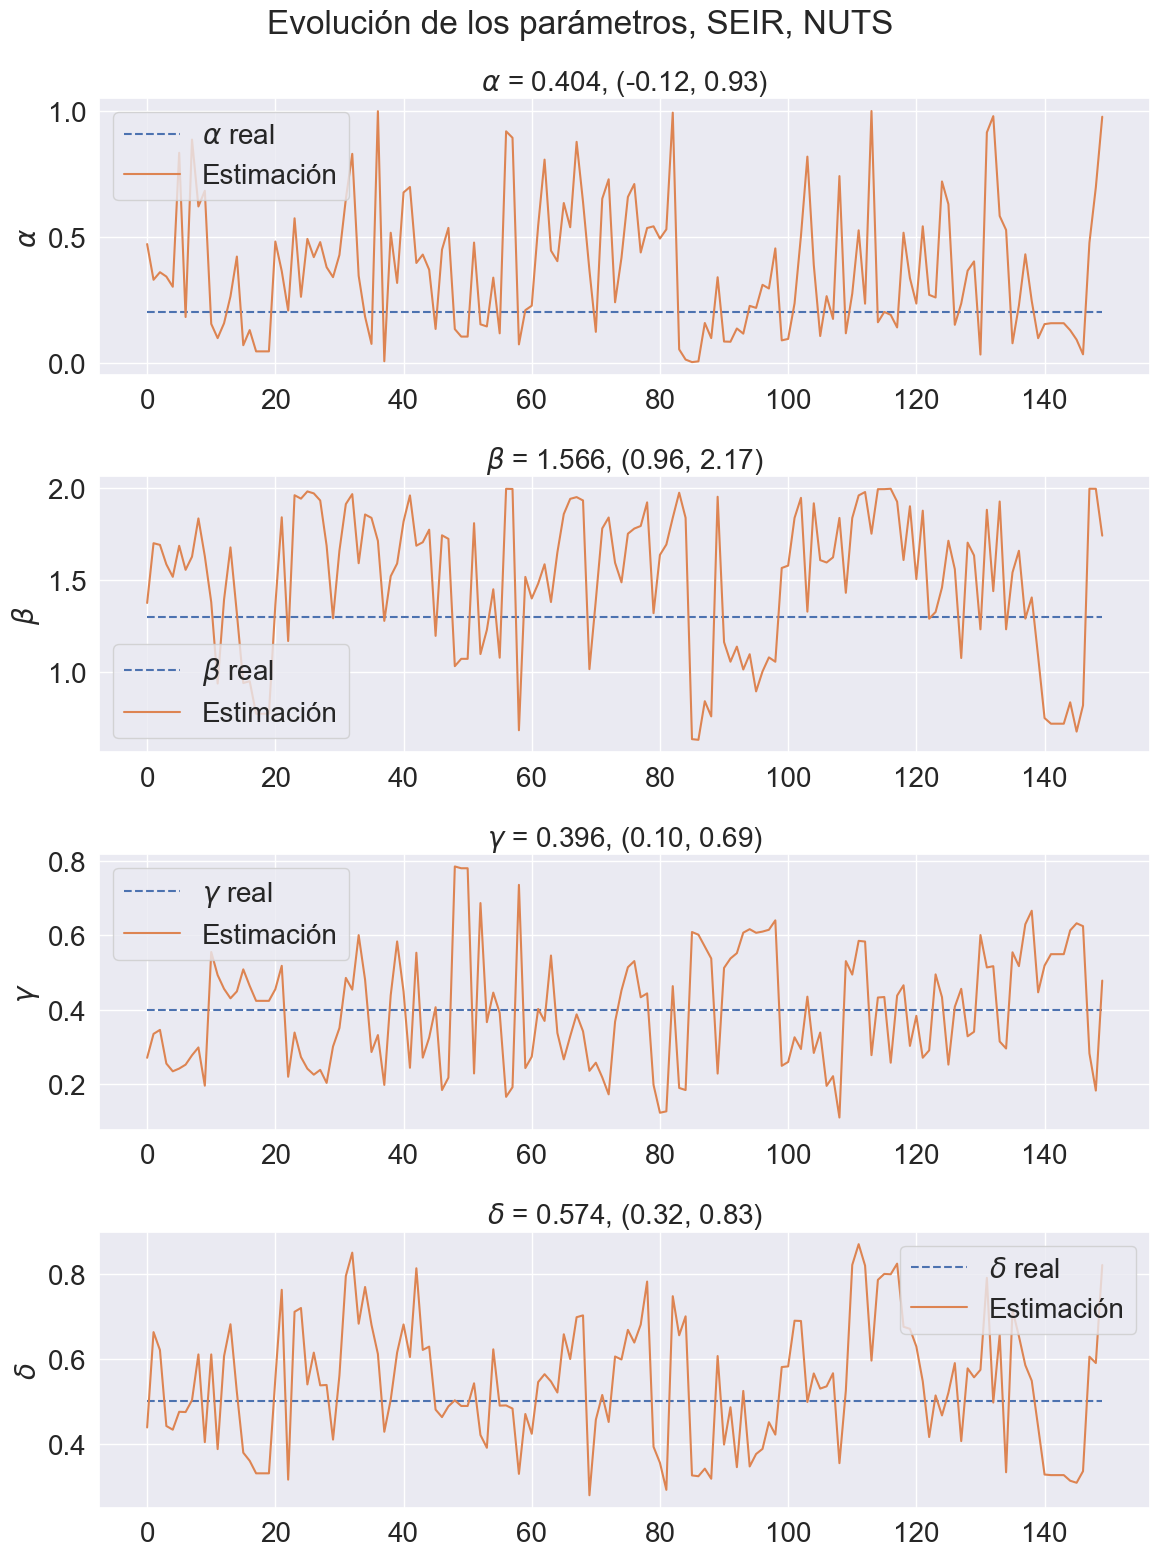

In [642]:
# Gráfico de la primera cadena a través de las iteraciones
fig, ax = plt.subplots(4, 1, figsize=(12, 16))

z1 = summ['mean']['alpha'] - 1.96*summ['sd']['alpha']
z2 = summ['mean']['alpha'] + 1.96*summ['sd']['alpha']
print(f"{'alpha'}: {summ['mean']['alpha']} ({z1}, {z2})")

ax[0].plot([0.2]*len(trace.posterior["alpha"][0]), linestyle='--', label=r'$\alpha$ real')
ax[0].plot(trace.posterior["alpha"][0], label='Estimación')
ax[0].set_title(r'$\alpha$ = {}, ({:.2f}, {:.2f})'.format(summ['mean']['alpha'], z1, z2))
ax[0].set_ylabel(r'$\alpha$')
ax[0].legend()

z1 = summ['mean']['beta'] - 1.96*summ['sd']['beta']
z2 = summ['mean']['beta'] + 1.96*summ['sd']['beta']
print(f"{'beta'}: {summ['mean']['beta']} ({z1}, {z2})")

ax[1].plot([1.3]*len(trace.posterior["beta"][0]), linestyle='--', label=r'$\beta$ real')
ax[1].plot(trace.posterior["beta"][0], label='Estimación')
ax[1].set_title(r'$\beta$ = {}, ({:.2f}, {:.2f})'.format(summ['mean']['beta'], z1, z2))
ax[1].set_ylabel(r'$\beta$')
ax[1].legend()

z1 = summ['mean']['gamma'] - 1.96*summ['sd']['gamma']
z2 = summ['mean']['gamma'] + 1.96*summ['sd']['gamma']
print(f"{'gamma'}: {summ['mean']['gamma']} ({z1}, {z2})")

ax[2].plot([0.4]*len(trace.posterior["gamma"][0]), linestyle='--', label=r'$\gamma$ real')
ax[2].plot(trace.posterior["gamma"][0], label='Estimación')
ax[2].set_title(r'$\gamma$ = {}, ({:.2f}, {:.2f})'.format(summ['mean']['gamma'], z1, z2))
ax[2].set_ylabel(r'$\gamma$')
ax[2].legend()

z1 = summ['mean']['delta'] - 1.96*summ['sd']['delta']
z2 = summ['mean']['delta'] + 1.96*summ['sd']['delta']
print(f"{'delta'}: {summ['mean']['delta']} ({z1}, {z2})")

ax[3].plot([0.5]*len(trace.posterior["delta"][0]), linestyle='--', label=r'$\delta$ real')
ax[3].plot(trace.posterior["delta"][0], label='Estimación')
ax[3].set_title(r'$\delta$ = {}, ({:.2f}, {:.2f})'.format(summ['mean']['delta'], z1, z2))
ax[3].set_ylabel(r'$\delta$')
ax[3].legend()

plt.suptitle('Evolución de los parámetros, SEIR, NUTS')
plt.tight_layout()
plt.savefig(img_path+'NUTS_seir_params_trace.pdf')

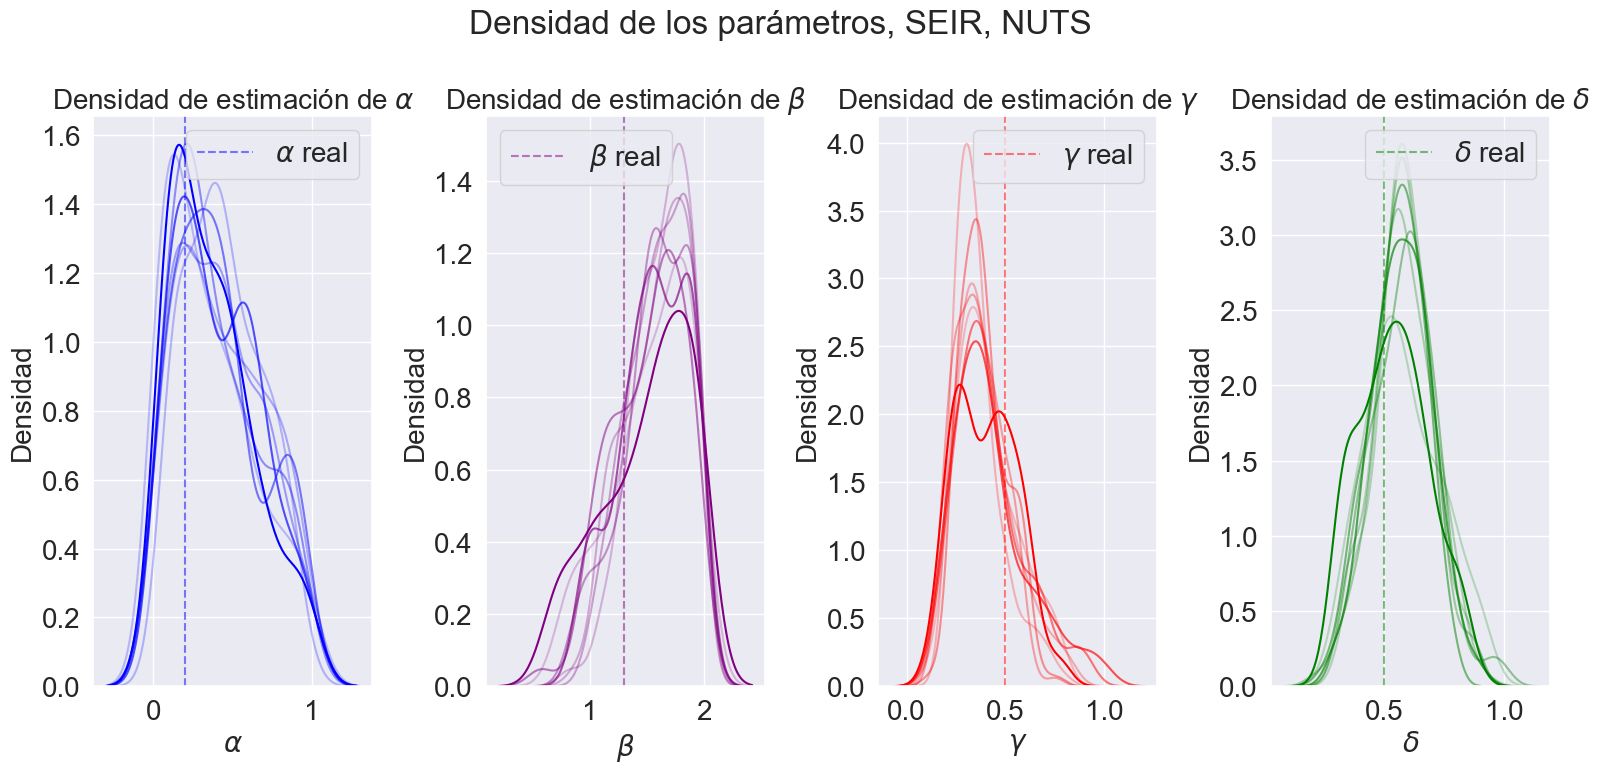

In [643]:
fig, ax = plt.subplots(1, 4, figsize=(16, 8))

for i in range(8):
    sns.kdeplot(trace.posterior["alpha"][i], ax=ax[0], color='blue', alpha=1/(i*0.5+1))
    sns.kdeplot(trace.posterior["beta"][i], ax=ax[1], color='purple', alpha=1/(i*0.5+1))
    sns.kdeplot(trace.posterior["gamma"][i], ax=ax[2], color='red', alpha=1/(i*0.5+1))
    sns.kdeplot(trace.posterior["delta"][i], ax=ax[3], color='green', alpha=1/(i*0.5+1))

ax[0].axvline(0.2, color='blue', linestyle='--', label=r'$\alpha$ real', alpha=0.5)
ax[0].set_title(r'Densidad de estimación de $\alpha$')
ax[0].set_xlabel(r'$\alpha$')
ax[0].set_ylabel('Densidad')
ax[0].legend()

ax[1].axvline(1.3, color='purple', linestyle='--', label=r'$\beta$ real', alpha=0.5)
ax[1].set_title(r'Densidad de estimación de $\beta$')
ax[1].set_xlabel(r'$\beta$')
ax[1].set_ylabel('Densidad')
ax[1].legend()

ax[2].axvline(0.5, color='red', linestyle='--', label=r'$\gamma$ real', alpha=0.5)
ax[2].set_title(r'Densidad de estimación de $\gamma$')
ax[2].set_xlabel(r'$\gamma$')
ax[2].set_ylabel('Densidad')
ax[2].legend()

ax[3].axvline(0.5, color='green', linestyle='--', label=r'$\delta$ real', alpha=0.5)
ax[3].set_title(r'Densidad de estimación de $\delta$')
ax[3].set_xlabel(r'$\delta$')
ax[3].set_ylabel('Densidad')
ax[3].legend()

fig.suptitle(r'Densidad de los parámetros, SEIR, NUTS')
plt.tight_layout()
plt.savefig(img_path+'NUTS_seir_params_density.pdf')

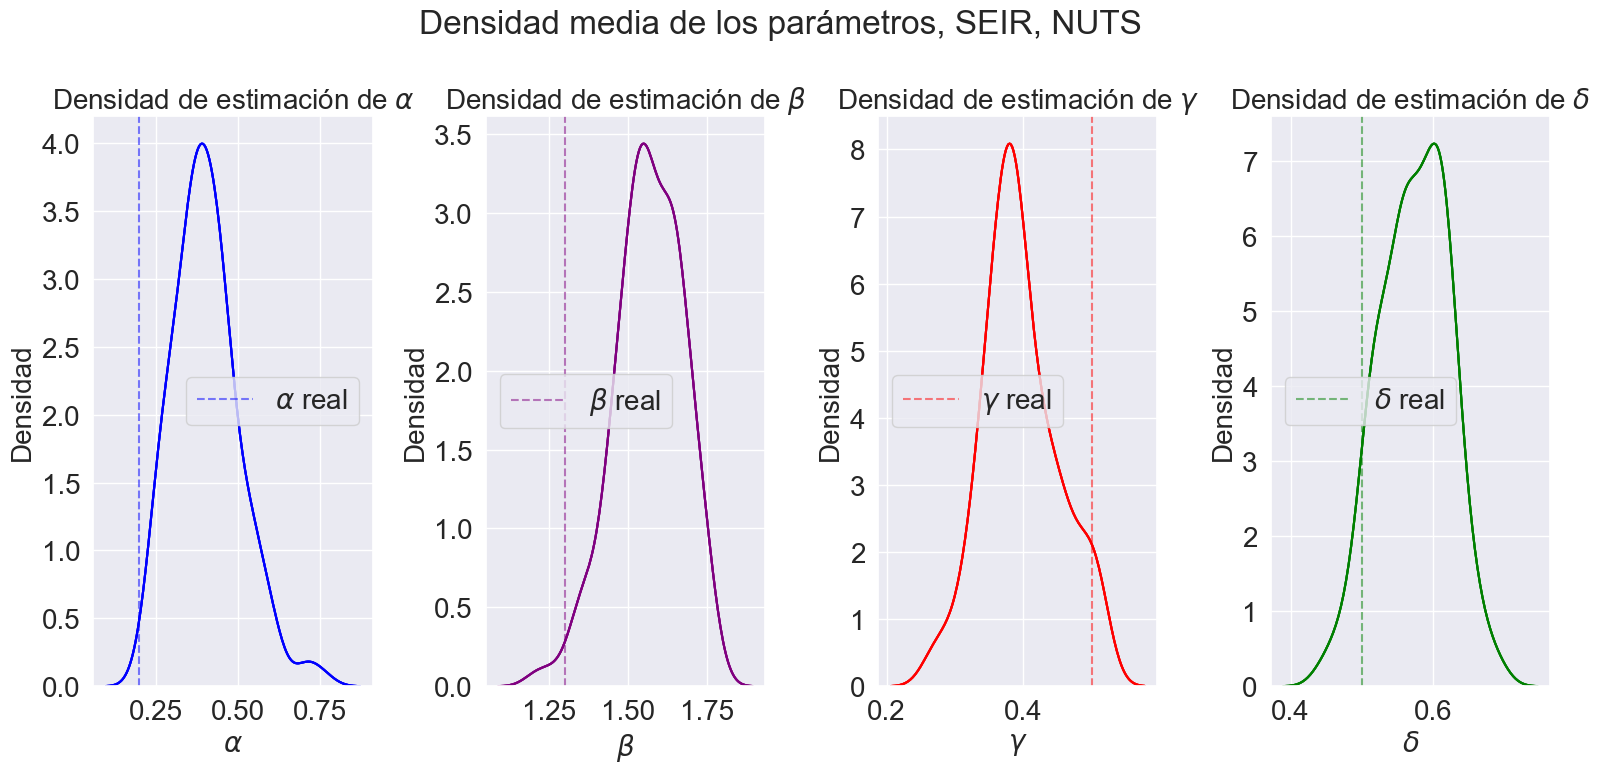

In [644]:
fig, ax = plt.subplots(1, 4, figsize=(16, 8))

for i in range(8):
    sns.kdeplot(trace.posterior["alpha"].mean(axis=0), ax=ax[0], color='blue', alpha=1/(i*0.5+1))
    sns.kdeplot(trace.posterior["beta"].mean(axis=0), ax=ax[1], color='purple', alpha=1/(i*0.5+1))
    sns.kdeplot(trace.posterior["gamma"].mean(axis=0), ax=ax[2], color='red', alpha=1/(i*0.5+1))
    sns.kdeplot(trace.posterior["delta"].mean(axis=0), ax=ax[3], color='green', alpha=1/(i*0.5+1))

ax[0].axvline(0.2, color='blue', linestyle='--', label=r'$\alpha$ real', alpha=0.5)
ax[0].set_title(r'Densidad de estimación de $\alpha$')
ax[0].set_xlabel(r'$\alpha$')
ax[0].set_ylabel('Densidad')
ax[0].legend()

ax[1].axvline(1.3, color='purple', linestyle='--', label=r'$\beta$ real', alpha=0.5)
ax[1].set_title(r'Densidad de estimación de $\beta$')
ax[1].set_xlabel(r'$\beta$')
ax[1].set_ylabel('Densidad')
ax[1].legend()

ax[2].axvline(0.5, color='red', linestyle='--', label=r'$\gamma$ real', alpha=0.5)
ax[2].set_title(r'Densidad de estimación de $\gamma$')
ax[2].set_xlabel(r'$\gamma$')
ax[2].set_ylabel('Densidad')
ax[2].legend()

ax[3].axvline(0.5, color='green', linestyle='--', label=r'$\delta$ real', alpha=0.5)
ax[3].set_title(r'Densidad de estimación de $\delta$')
ax[3].set_xlabel(r'$\delta$')
ax[3].set_ylabel('Densidad')
ax[3].legend()

fig.suptitle(r'Densidad media de los parámetros, SEIR, NUTS')
plt.tight_layout()
plt.savefig(img_path+'NUTS_seir_params_density_mean.pdf')